In [ ]:
# =======================
#  Mount Google Drive (Colab)
# =======================

from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


In [ ]:
# =======================
#  Install dependencies (Transformers/Captum)
# =======================


!pip install  transformers datasets
!pip install  captum


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 131.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.13.0.90 requires numpy>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
pytensor 2.37.0 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
rasterio 1.5.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.13.0.90 requires numpy>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.13.0

In [ ]:
# =======================
# 2) Install LIME
# =======================


!pip install lime


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 9.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=1394cc4de67eb2188ae7073ef2ace77a75d4312345b4aefd7e20704dfe88afcd
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [ ]:
# =======================
# 3) Imports & Configuration
# =======================


import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Output directory for plots and saved artifacts
OUT_DIR = "plots6"
os.makedirs(OUT_DIR, exist_ok=True)

# Dataset configuration 
CSV_PATH = "/content/test_constructed_targetSEPonly (1).csv"
TEXT_COL = "context_text_raw"   # column containing input text
LABEL_COL = "label"      # set to None if your CSV has no labels

# Model configuration
MODEL_ID = "/content/drive/MyDrive/epoch_checkpoints_seed46_emoberta_roberta_iemocap_with_spaces/epoch_checkpoints_seed45/epoch_01"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==========  Load dataset ==========
df = pd.read_csv(CSV_PATH)
assert TEXT_COL in df.columns, f"Missing TEXT_COL='{TEXT_COL}' in CSV columns: {list(df.columns)}"
if LABEL_COL is not None:
    assert LABEL_COL in df.columns, f"Missing LABEL_COL='{LABEL_COL}' in CSV columns: {list(df.columns)}"

# ==========  Load tokenizer & model ==========
tokenizer = AutoTokenizer.from_pretrained("roberta-base", use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_ID,
    output_attentions=True
).to(DEVICE).eval()

print(f"[Loaded] {len(df)} rows from: {CSV_PATH}")
print(f"[Model] {MODEL_ID} on {DEVICE}")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

[Loaded] 1622 rows from: /content/test_constructed_targetSEPonly (1).csv
[Model] /content/drive/MyDrive/epoch_checkpoints_seed46_emoberta_roberta_iemocap_with_spaces/epoch_checkpoints_seed45/epoch_01 on cuda


In [ ]:
# =======================
# 4) Confusion Matrices — Functions
# =======================


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

def evaluate_confusion_matrices(
    model,
    tokenizer,
    df,
    text_col="Utterance",
    label_col="Label",
    max_length=128,
    batch_size=32,
    device=None,
    out_dir=None,
    file_prefix="cm",
    show_plots=True,
    save_plots=True,
):
    """
    Build y_true / y_pred from a labeled CSV, then plot and (optionally) save confusion matrices.

    Requirements:
      - df[label_col] should contain label names matching model.config.id2label (case-insensitive supported).
    """

    # Resolve output directory 
    if out_dir is None:
        out_dir = globals().get("OUT_DIR", "plots")
    if save_plots:
        os.makedirs(out_dir, exist_ok=True)

    # Resolve device
    if device is None:
        device = globals().get("DEVICE", None) or next(model.parameters()).device
    model.to(device).eval()

    # Map label strings 
    id2label = model.config.id2label
    num_classes = len(id2label)
    label2id = {id2label[i].lower(): i for i in range(num_classes)}

    # Prepare texts + ground truth labels
    texts = df[text_col].astype(str).tolist()
    raw_labels = df[label_col].astype(str).tolist()

    missing = sorted({l for l in raw_labels if l.lower() not in label2id})
    if missing:
        raise ValueError(
            f"Found labels not present in the model mapping: {missing}\n"
            f"Model labels are: {list(id2label.values())}"
        )

    y_true = np.array([label2id[l.lower()] for l in raw_labels], dtype=int)

    # Batched prediction
    preds = []
    with torch.inference_mode():
        for start in range(0, len(texts), batch_size):
            batch = texts[start:start + batch_size]
            enc = tokenizer(
                batch,
                return_tensors="pt",
                padding=True,
                truncation=True,
                max_length=max_length
            )
            enc = {k: v.to(device) for k, v in enc.items()}
            logits = model(**enc).logits
            preds.append(logits.argmax(dim=-1).detach().cpu().numpy())
    y_pred = np.concatenate(preds, axis=0)

    # Class names in order
    class_names = [id2label[i] for i in range(num_classes)]
    labels_idx = list(range(num_classes))

    # Confusion matrices
    cm_counts = confusion_matrix(y_true, y_pred, labels=labels_idx)
    cm_row    = confusion_matrix(y_true, y_pred, labels=labels_idx, normalize="true")
    cm_col    = confusion_matrix(y_true, y_pred, labels=labels_idx, normalize="pred")

    # Plot helper
    def _plot(cm, title, fname):
        fig, ax = plt.subplots(figsize=(7, 6))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
        disp.plot(include_values=True, cmap="Blues", xticks_rotation=45, ax=ax, colorbar=False)
        ax.set_title(title)
        ax.set_xlabel("Predicted")
        ax.set_ylabel("True")
        plt.tight_layout()

        if save_plots:
            path = os.path.join(out_dir, fname)
            plt.savefig(path, bbox_inches="tight", dpi=150)
            print("[saved]", path)

        if show_plots:
            plt.show()

        plt.close(fig)

    # Save/Show plots (always into out_dir you defined)
    _plot(cm_counts, "Confusion Matrix (counts)",                f"{file_prefix}_counts.png")
    _plot(cm_row,    "Confusion Matrix (row-norm = recall)",     f"{file_prefix}_row_norm.png")
    _plot(cm_col,    "Confusion Matrix (col-norm = precision)",  f"{file_prefix}_col_norm.png")

    # Print metrics
    print(classification_report(y_true, y_pred, target_names=class_names, digits=3))

    return {
        "cm_counts": cm_counts,
        "cm_row_norm": cm_row,
        "cm_col_norm": cm_col,
        "class_names": class_names,
        "y_true": y_true,
        "y_pred": y_pred,
    }

# Example call (uses your existing globals)
# results = evaluate_confusion_matrices(model, tokenizer, df, text_col=TEXT_COL, label_col=LABEL_COL)


[saved] plots6/erc_cm_counts.png


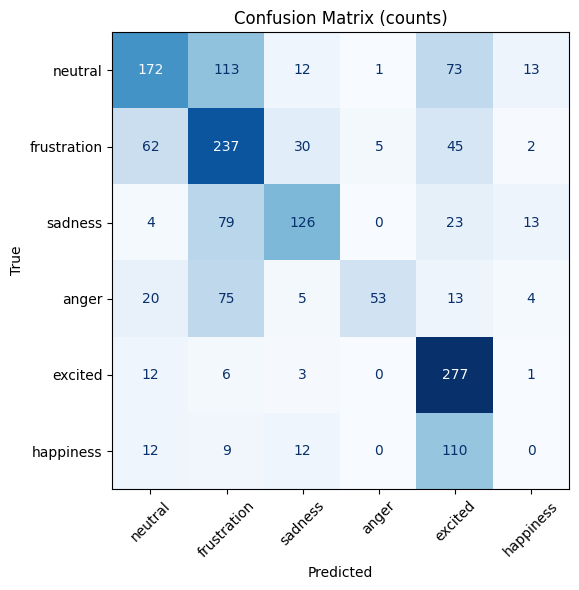

[saved] plots6/erc_cm_row_norm.png


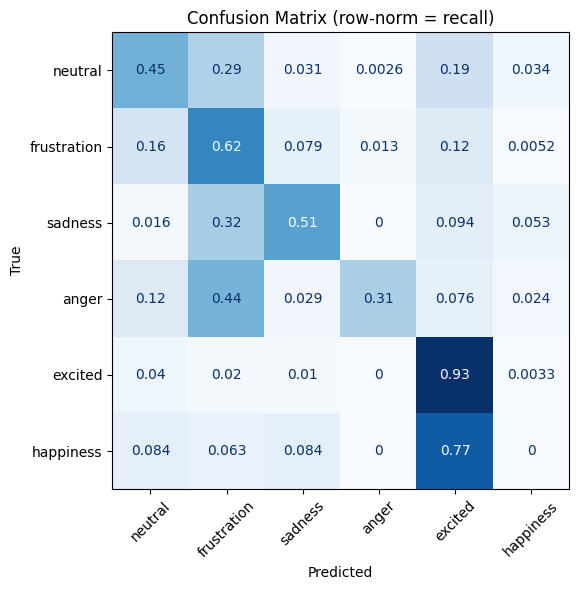

[saved] plots6/erc_cm_col_norm.png


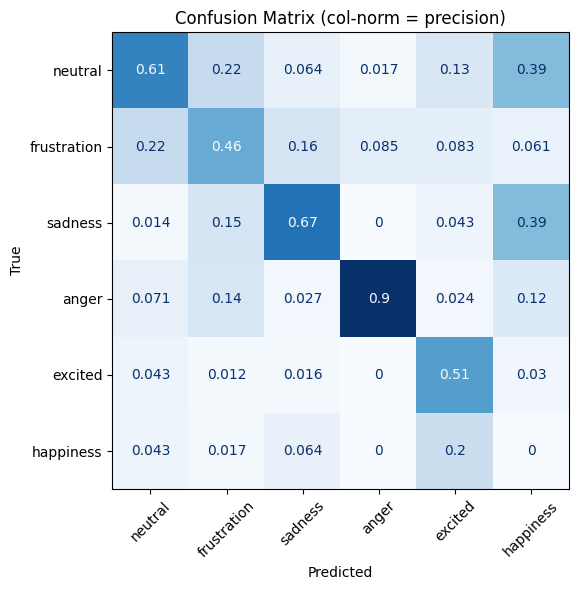

              precision    recall  f1-score   support

     neutral      0.610     0.448     0.517       384
 frustration      0.457     0.622     0.527       381
     sadness      0.670     0.514     0.582       245
       anger      0.898     0.312     0.463       170
     excited      0.512     0.926     0.660       299
   happiness      0.000     0.000     0.000       143

    accuracy                          0.533      1622
   macro avg      0.525     0.470     0.458      1622
weighted avg      0.541     0.533     0.504      1622



In [ ]:
# =======================
# 5) Confusion Matrices - exec
# =======================


results = evaluate_confusion_matrices(
    model=model,
    tokenizer=tokenizer,
    df=df,
    text_col=TEXT_COL,
    label_col=LABEL_COL,
    max_length=128,
    batch_size=32,
    device=DEVICE,
    out_dir=OUT_DIR,
    file_prefix="erc_cm",
    show_plots=True,
    save_plots=True,
)


In [ ]:
# =======================
# 6) Dataset Inference (batched)
# =======================


BATCH_SIZE = 32
MAX_LENGTH = 128
SAVE_PRED_CSV = True

assert TEXT_COL in df.columns, f"Missing TEXT_COL='{TEXT_COL}' in df.columns"

texts = df[TEXT_COL].astype(str).tolist()

all_pred_ids = []
all_pred_labels = []

model.eval()

id2label = model.config.id2label # Added this line to define id2label

with torch.inference_mode():
    for start in range(0, len(texts), BATCH_SIZE):
        batch_texts = texts[start:start + BATCH_SIZE]

        enc = tokenizer(
            batch_texts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=MAX_LENGTH
        )
        enc = {k: v.to(DEVICE) for k, v in enc.items()}

        logits = model(**enc, return_dict=True).logits  # (B, C)
        pred_ids = logits.argmax(dim=-1).detach().cpu().numpy().tolist()

        all_pred_ids.extend(pred_ids)
        all_pred_labels.extend([id2label[i] for i in pred_ids])

df["pred_id"] = all_pred_ids
df["pred_label"] = all_pred_labels

print(f"[Inference] Ran predictions for {len(texts)} rows.")
print("[Sanity] First utterance:", texts[0])
print("[Sanity] First pred:", df.loc[0, "pred_label"], f"(id={df.loc[0, 'pred_id']})")

if SAVE_PRED_CSV:
    out_path = os.path.join(OUT_DIR, "predictions.csv")
    df.to_csv(out_path, index=False)
    print("[saved]", out_path)


[Inference] Ran predictions for 1622 rows.
[Sanity] First utterance: <s> </s> ELIZABETH: Hi, I need an ID. </s> WILLIAM: ahh Yeah, this is the wrong line. I'm sorry. You need to go back over to line two B. That's where you should have started from. ELIZABETH: Okay, I'm sorry, but I just stood in this line for an hour. can I Is there any way I can- ELIZABETH: No, they told me-I'm sorry, but they told me to be in this line. ELIZABETH: What, I mean what... what's the difference? What do I need to do there that I can't do here? WILLIAM: Well, I have no camera here. I can't help you at all here, ma'am. I have forms for something completely different. You need to go to a different place. ELIZABETH: Can you just-can I just get the right- WILLIAM: Simply step to line two A, ma'am, I'm sorry. ELIZABETH: Would you be able to put me at the front of that line? WILLIAM: There is a large line of people behind you waiting to be-- ELIZABETH: I know. I've been in line with these people. I understand. I

In [ ]:
# =======================
# 7) Install & Import SHAP
# =======================

!pip install shap
import shap


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 116.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
captum 0.8.0 requires numpy<2.0, but you have numpy 2.0.2 which is incompatible.


[Classes] ['neutral', 'frustration', 'sadness', 'anger', 'excited', 'happiness']
[Data] Using 1622 rows | labels=YES
[GradSHAP] 0/1622
[GradSHAP] 200/1622
[GradSHAP] 400/1622
[GradSHAP] 600/1622
[GradSHAP] 800/1622
[GradSHAP] 1000/1622
[GradSHAP] 1200/1622
[GradSHAP] 1400/1622
[GradSHAP] 1600/1622
[Done] Global GradSHAP aggregation complete.
[saved] plots6/global_gradshap_words_neutral.png


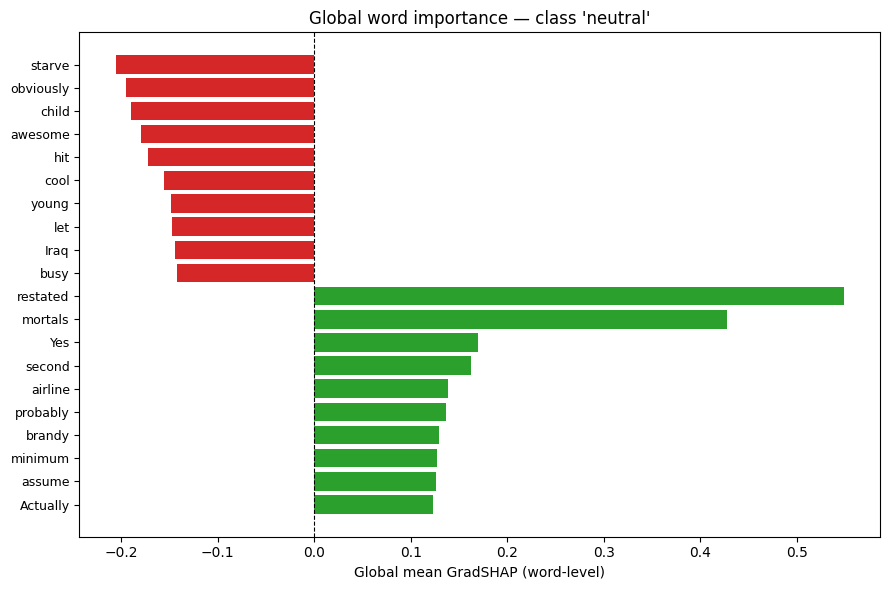

[saved] plots6/global_gradshap_words_frustration.png


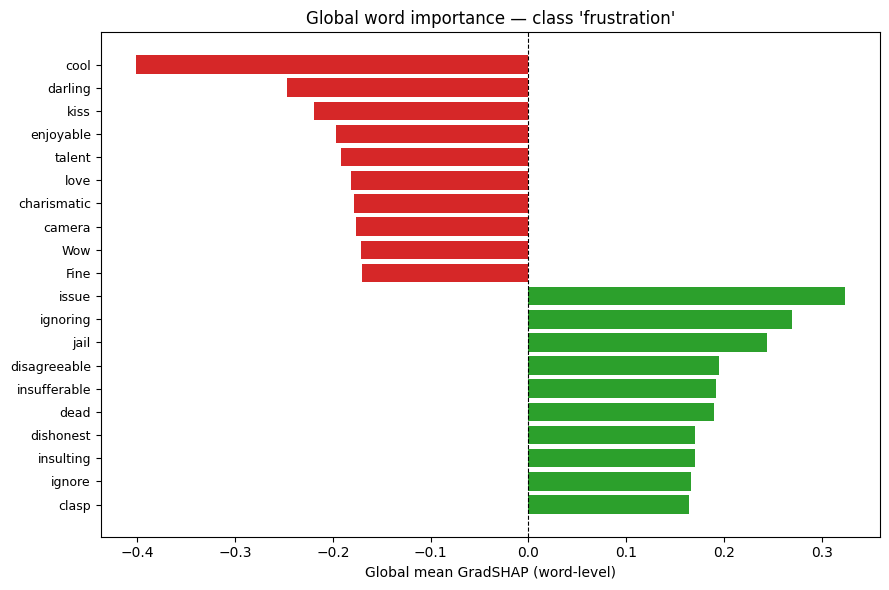

[saved] plots6/global_gradshap_words_sadness.png


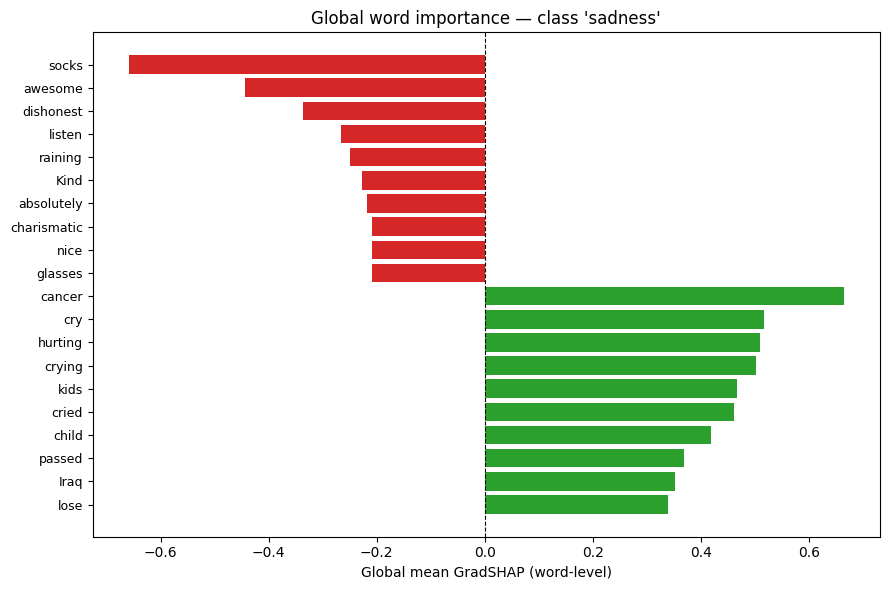

[saved] plots6/global_gradshap_words_anger.png


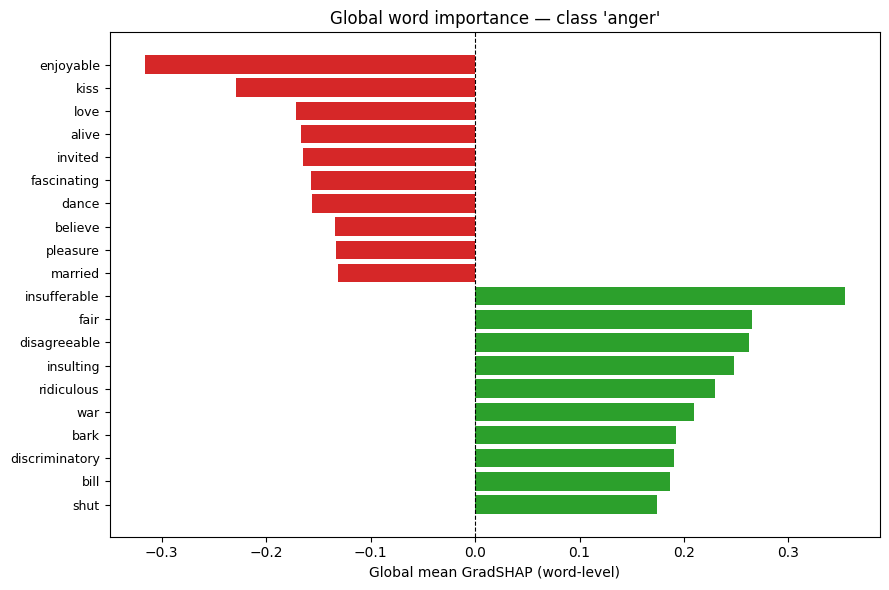

[saved] plots6/global_gradshap_words_excited.png


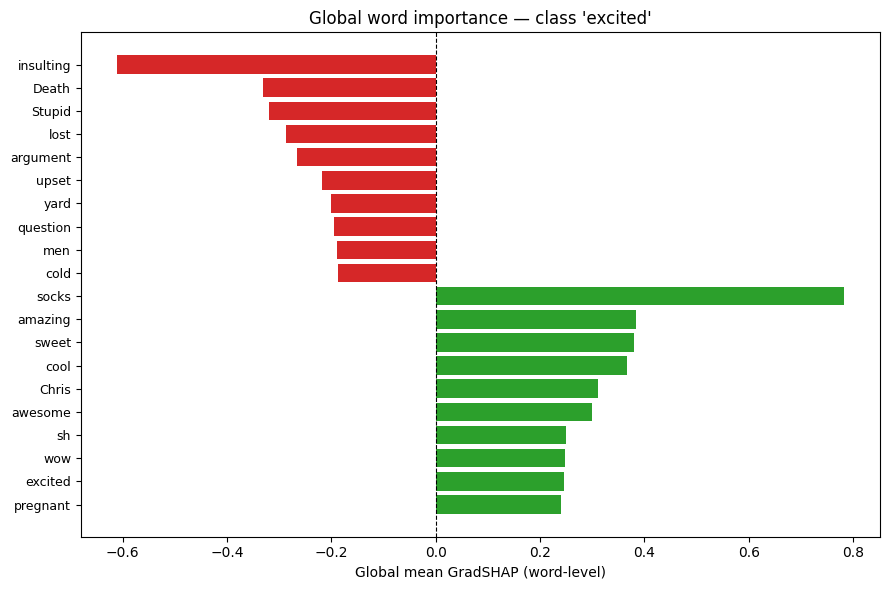

[saved] plots6/global_gradshap_words_happiness.png


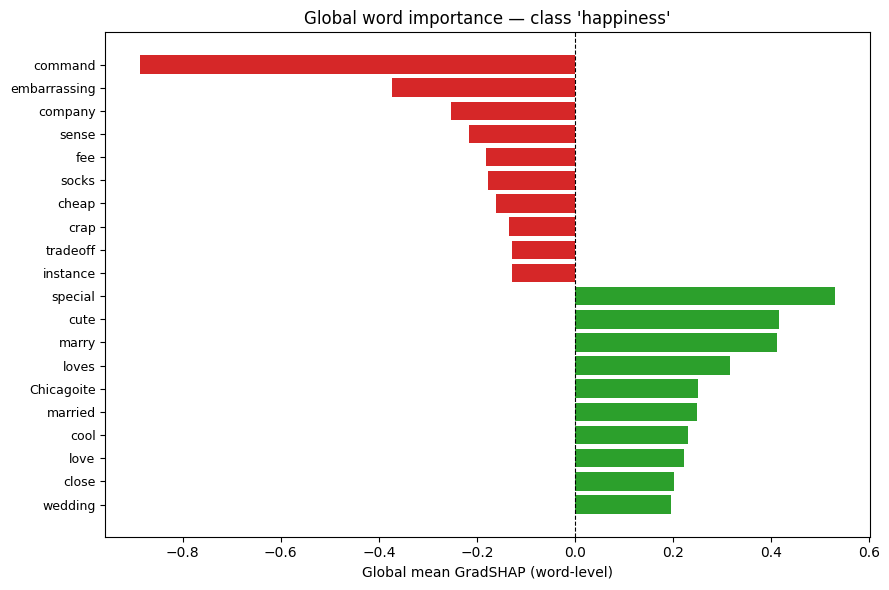

In [ ]:
# =======================
# 8) Corpus-level GradSHAP aggregation
# =======================


from collections import defaultdict
from captum.attr import GradientShap

assert getattr(tokenizer, "is_fast", False), "This method requires a FAST tokenizer (use_fast=True)."

# ---- Parameters (tune for speed/quality) ----
MAX_LENGTH = 128
N_UTTERANCES = 5400   # set None to use all rows
NSAMPLES = 20         # GradientSHAP samples (lower = faster)
TOP_K_POS = 10
TOP_K_NEG = 10
SHOW_PLOTS = True
SAVE_PLOTS = True
VERBOSE_EVERY = 200   # print progress every N examples (set None to disable)

# ---- Resolve columns from your config ----
assert TEXT_COL in df.columns, f"Missing TEXT_COL='{TEXT_COL}' in df.columns"
use_labels = (LABEL_COL is not None) and (LABEL_COL in df.columns)

texts = df[TEXT_COL].astype(str).tolist()
raw_labels = df[LABEL_COL].astype(str).tolist() if use_labels else None

if N_UTTERANCES is not None:
    texts = texts[:N_UTTERANCES]
    if raw_labels is not None:
        raw_labels = raw_labels[:N_UTTERANCES]

# ---- Label mapping (string label -> id) ----
id2label_local = model.config.id2label
num_classes = len(id2label_local)
class_names = [id2label_local[i] for i in range(num_classes)]
label2id_lower = {id2label_local[i].lower(): i for i in range(num_classes)}

print("[Classes]", class_names)
print(f"[Data] Using {len(texts)} rows | labels={'YES' if use_labels else 'NO'}")

# ---- Captum forward: embeddings -> logits ----
def forward_func(inputs_embeds, attention_mask):
    out = model(inputs_embeds=inputs_embeds, attention_mask=attention_mask, return_dict=True)
    return out.logits  # (B, C)

grad_shap = GradientShap(forward_func)

# ---- Global accumulators: per-class (sum, count) over words ----
word_sum = [defaultdict(float) for _ in range(num_classes)]
word_cnt = [defaultdict(int)   for _ in range(num_classes)]

emb_layer = model.get_input_embeddings()
model.eval()

for i, text in enumerate(texts):
    if VERBOSE_EVERY and (i % VERBOSE_EVERY == 0):
        print(f"[GradSHAP] {i}/{len(texts)}")

    # Tokenize with offsets + word_ids (fast tokenizer only)
    enc = tokenizer(
        text,
        return_tensors="pt",
        padding=False,
        truncation=True,
        max_length=MAX_LENGTH,
        add_special_tokens=True,
        return_attention_mask=True,
        return_offsets_mapping=True
    )

    input_ids = enc["input_ids"].to(DEVICE)              # (1, L)
    attention_mask = enc["attention_mask"].to(DEVICE)    # (1, L)
    offsets = enc["offset_mapping"][0].tolist()          # list[(start,end)]
    word_ids = enc.word_ids(0)                           # list[int|None], length L

    # Choose target class for this sample
    target_idx = None
    if use_labels:
        target_idx = label2id_lower.get(raw_labels[i].lower(), None)

    if target_idx is None:
        # Fallback: use model prediction
        with torch.inference_mode():
            logits = model(input_ids=input_ids, attention_mask=attention_mask, return_dict=True).logits
        target_idx = int(logits.argmax(dim=-1).item())

    # Embeddings + baseline
    embeds = emb_layer(input_ids).detach().requires_grad_(True)  
    baseline = torch.zeros_like(embeds)

    model.zero_grad(set_to_none=True)

    attributions = grad_shap.attribute(
        embeds,
        baselines=baseline,
        target=target_idx,
        additional_forward_args=(attention_mask,),
        n_samples=NSAMPLES,
        stdevs=0.0
    )  

    # Collapse hidden dim -> per-token score
    token_attr = attributions.sum(dim=-1).squeeze(0).detach().cpu().numpy()  # (L,)

    # Aggregate subwords into words (mean over subwords)
    wid_sum = {}
    wid_cnt = {}
    wid_start = {}
    wid_end = {}

    for tidx, (wid, (s, e)) in enumerate(zip(word_ids, offsets)):
        if wid is None:
            continue  # special tokens

        wid_sum[wid] = wid_sum.get(wid, 0.0) + float(token_attr[tidx])
        wid_cnt[wid] = wid_cnt.get(wid, 0) + 1

        if wid not in wid_start:
            wid_start[wid], wid_end[wid] = s, e
        else:
            wid_start[wid] = min(wid_start[wid], s)
            wid_end[wid] = max(wid_end[wid], e)

    # Update global word stats for the chosen class
    for wid, s in wid_sum.items():
        mean_attr = s / max(1, wid_cnt[wid])

        w = text[wid_start[wid]:wid_end[wid]].strip()
        if not w:
            continue

       

        word_sum[target_idx][w] += mean_attr
        word_cnt[target_idx][w] += 1

print("[Done] Global GradSHAP aggregation complete.")

# ---- Compute global means per class ----
global_word_means = {}
for c in range(num_classes):
    global_word_means[c] = {
        w: word_sum[c][w] / word_cnt[c][w]
        for w in word_sum[c].keys()
        if word_cnt[c][w] > 0
    }

# ---- Plot top positive/negative words per class ----
if SAVE_PLOTS:
    os.makedirs(OUT_DIR, exist_ok=True)

for c in range(num_classes):
    cname = class_names[c]
    w2m = global_word_means[c]
    if not w2m:
        print(f"[Plot] No words for class '{cname}', skipping.")
        continue

    words = np.array(list(w2m.keys()))
    vals = np.array([w2m[w] for w in words], dtype=float)

    pos_idx = np.where(vals > 0)[0]
    neg_idx = np.where(vals < 0)[0]

    # Top-K
    pos_keep = pos_idx[np.argsort(vals[pos_idx])[-TOP_K_POS:]][::-1] if len(pos_idx) else np.array([], dtype=int)
    neg_keep = neg_idx[np.argsort(vals[neg_idx])[:TOP_K_NEG]] if len(neg_idx) else np.array([], dtype=int)

    keep = np.concatenate([neg_keep, pos_keep])
    if keep.size == 0:
        print(f"[Plot] No non-zero words for class '{cname}', skipping.")
        continue

    plot_words = words[keep].tolist()
    plot_vals = vals[keep].tolist()
    y = np.arange(len(plot_words))

    plt.figure(figsize=(9, 6))
    colors = ["tab:red" if v < 0 else "tab:green" for v in plot_vals]
    plt.barh(y, plot_vals, color=colors)
    plt.yticks(y, plot_words, fontsize=9)
    plt.axvline(0, color="k", linestyle="--", linewidth=0.8)
    plt.xlabel("Global mean GradSHAP (word-level)")
    plt.title(f"Global word importance — class '{cname}'")
    plt.gca().invert_yaxis()
    plt.tight_layout()

    out_path = os.path.join(OUT_DIR, f"global_gradshap_words_{cname}.png")
    if SAVE_PLOTS:
        plt.savefig(out_path, dpi=150, bbox_inches="tight")
        print("[saved]", out_path)

    if SHOW_PLOTS:
        plt.show()
    plt.close()


In [ ]:
# =======================
# 9) Helper: predict_proba wrapper
# =======================
# Βοηθητική συνάρτηση για softmax πιθανότητες (χρήσιμη σε LIME/SHAP wrappers).

@torch.inference_mode()
def predict_proba(texts, max_length=128, batch_size=32):
    if isinstance(texts, str):
        texts = [texts]

    probs_all = []
    for start in range(0, len(texts), batch_size):
        batch = texts[start:start + batch_size]
        enc = tokenizer(
            batch,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=max_length
        )
        enc = {k: v.to(DEVICE) for k, v in enc.items()}
        logits = model(**enc, return_dict=True).logits
        probs = torch.softmax(logits, dim=-1).detach().cpu().numpy()
        probs_all.append(probs)

    return np.concatenate(probs_all, axis=0)


[pool] neutral: 30 samples
[pool] frustration: 30 samples
[pool] sadness: 30 samples
[pool] anger: 30 samples
[pool] excited: 30 samples
[pool] happiness: 30 samples
[compute] neutral: LGXA
[compute] neutral: LIG
[compute] frustration: LGXA
[compute] frustration: LIG
[compute] sadness: LGXA
[compute] sadness: LIG
[compute] anger: LGXA
[compute] anger: LIG
[compute] excited: LGXA
[compute] excited: LIG
[compute] happiness: LGXA
[compute] happiness: LIG
[info] baseline for delta: neutral


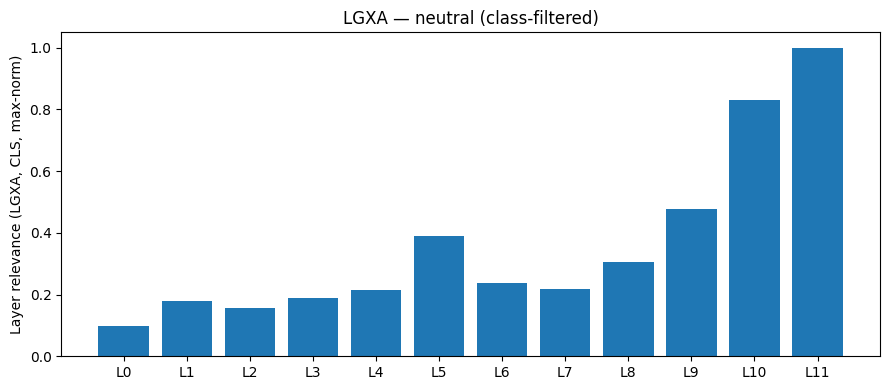

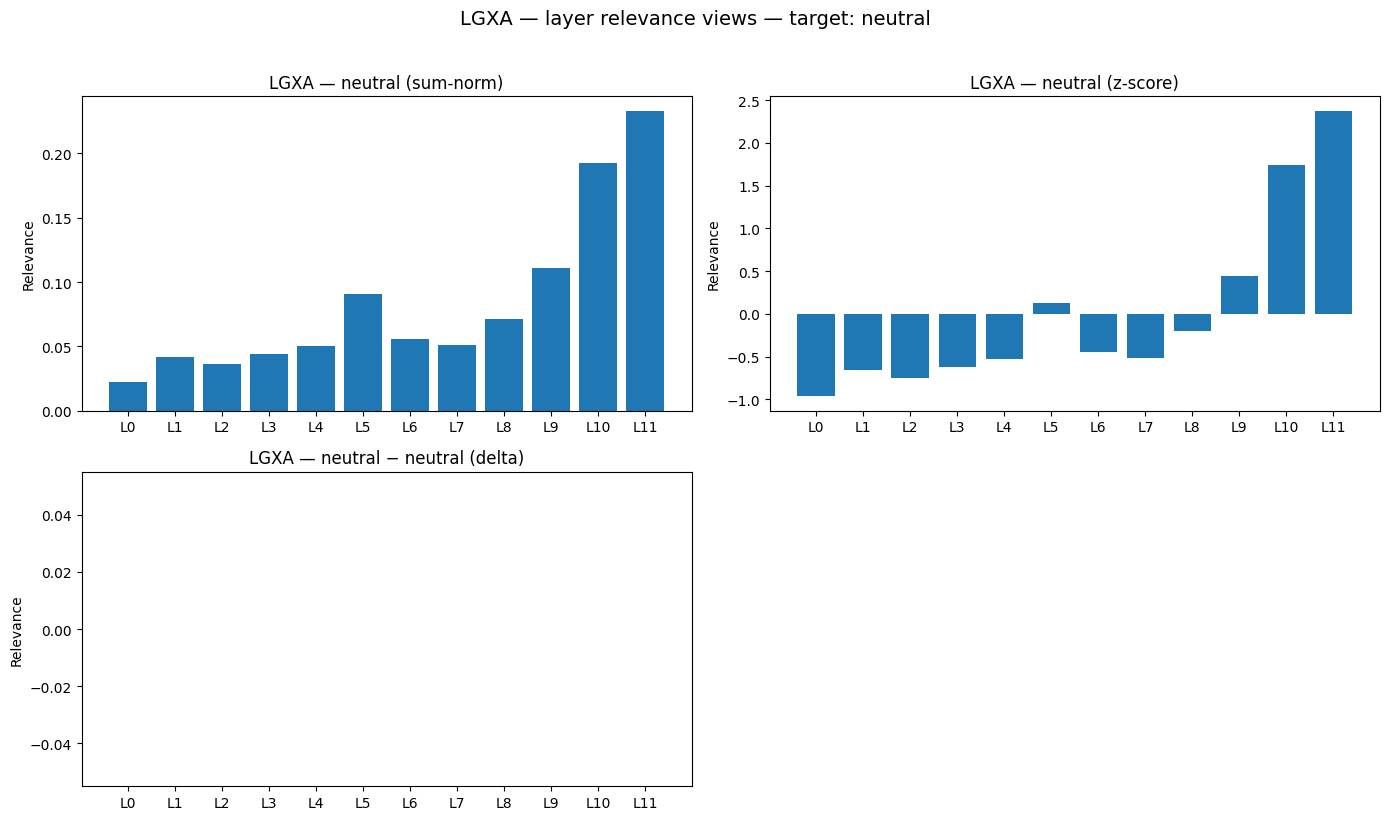

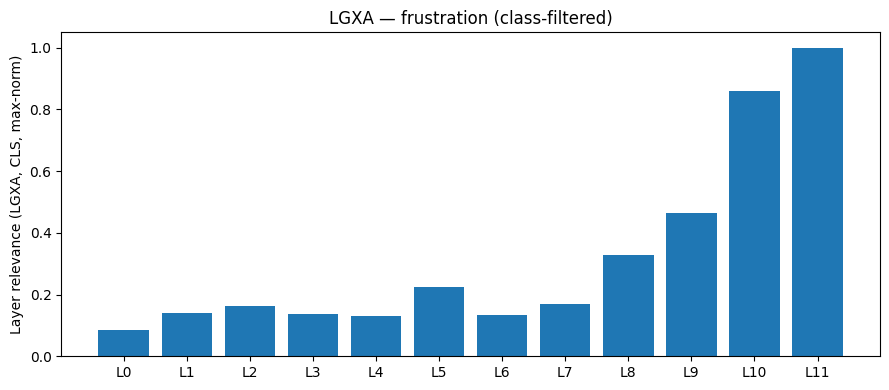

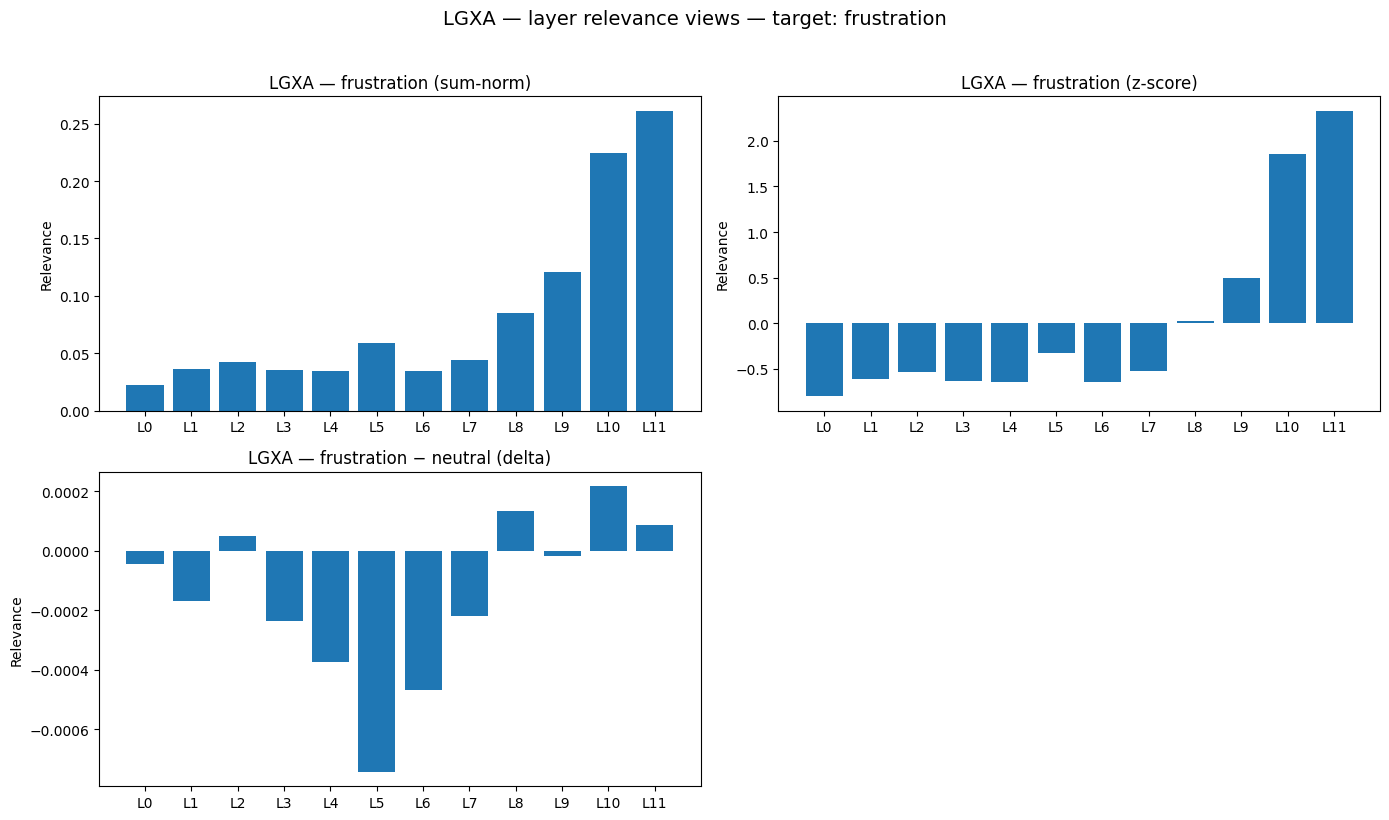

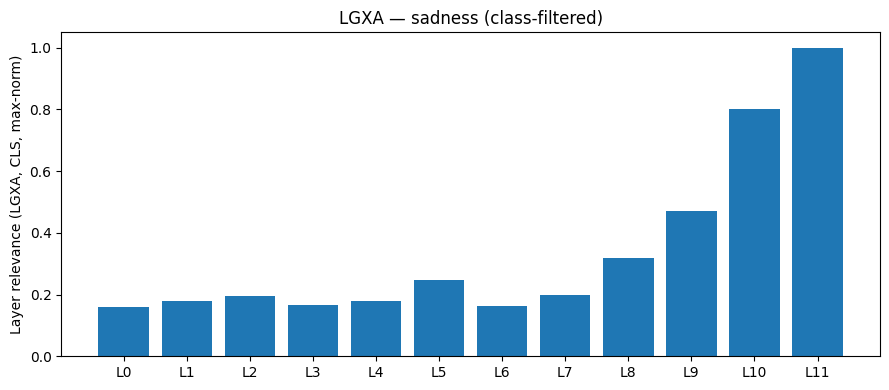

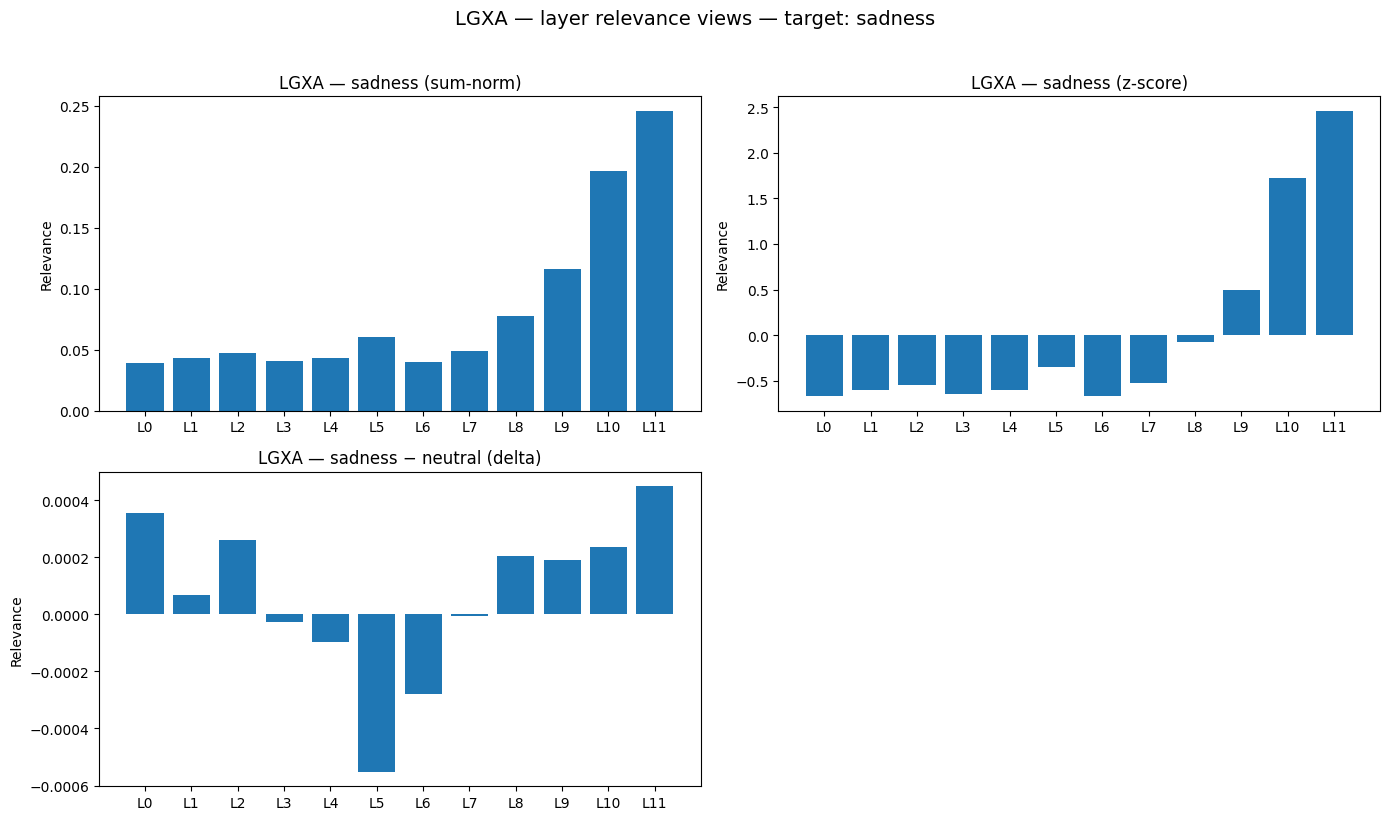

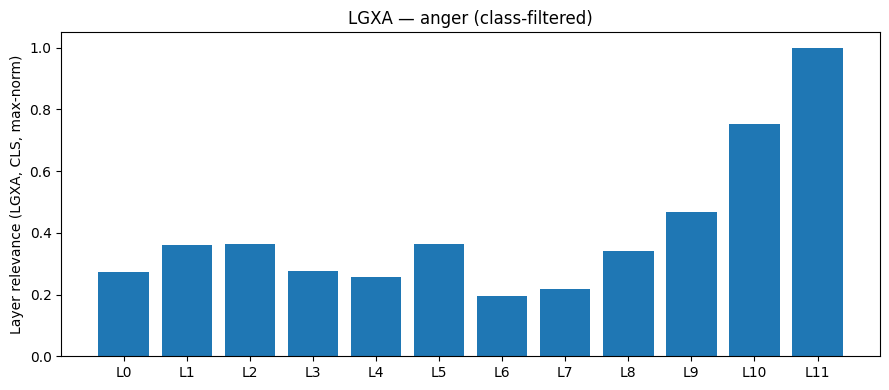

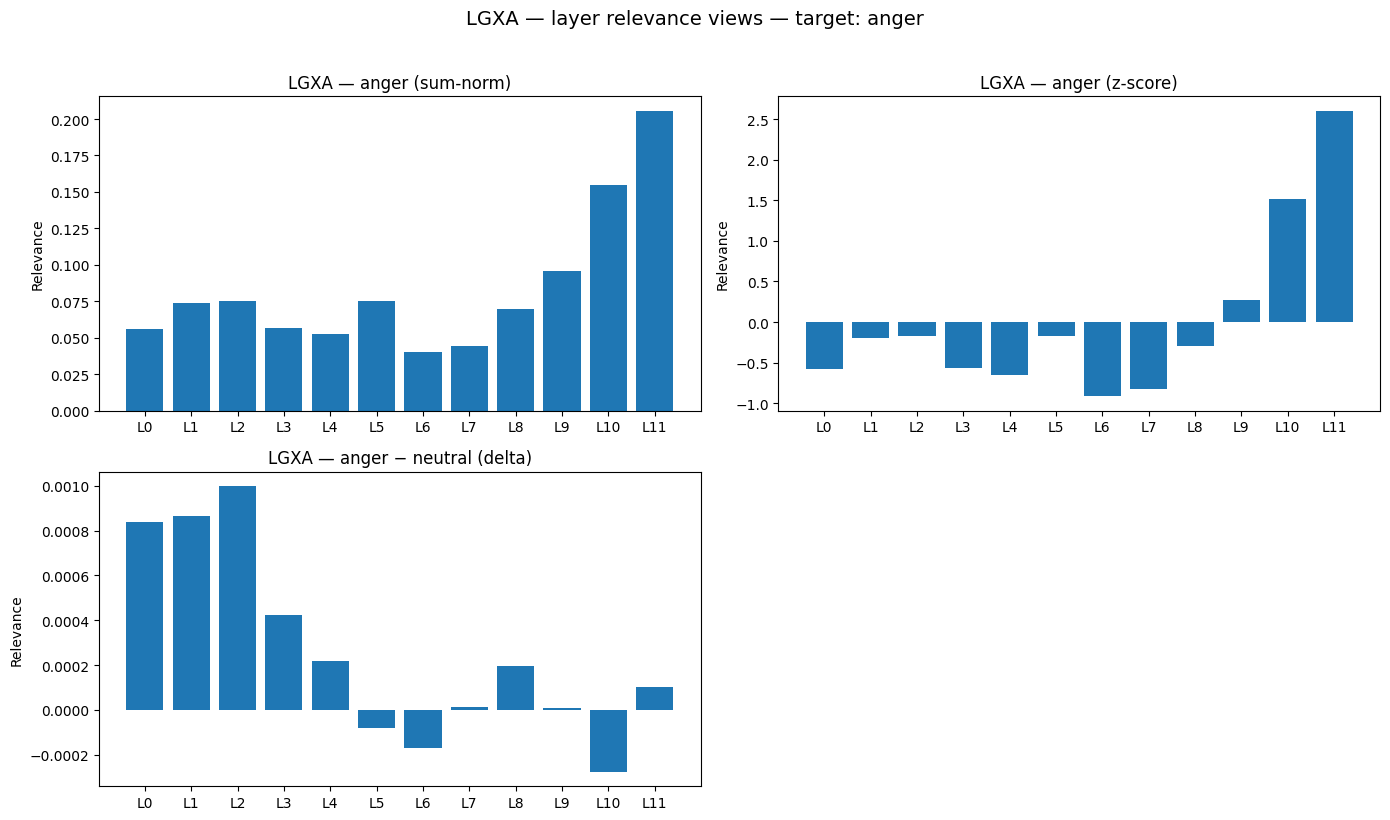

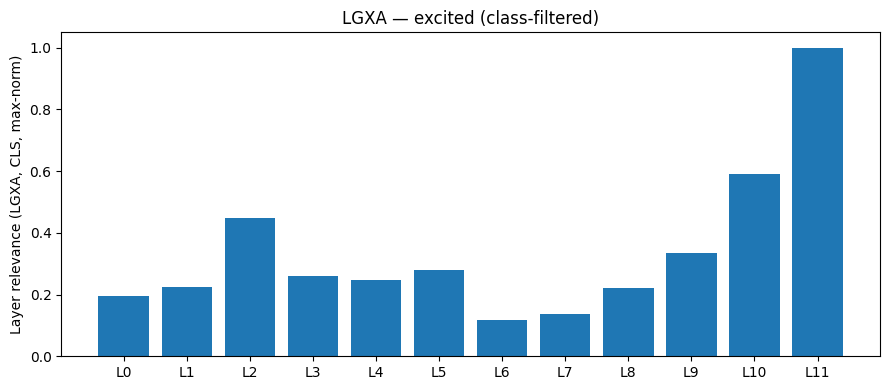

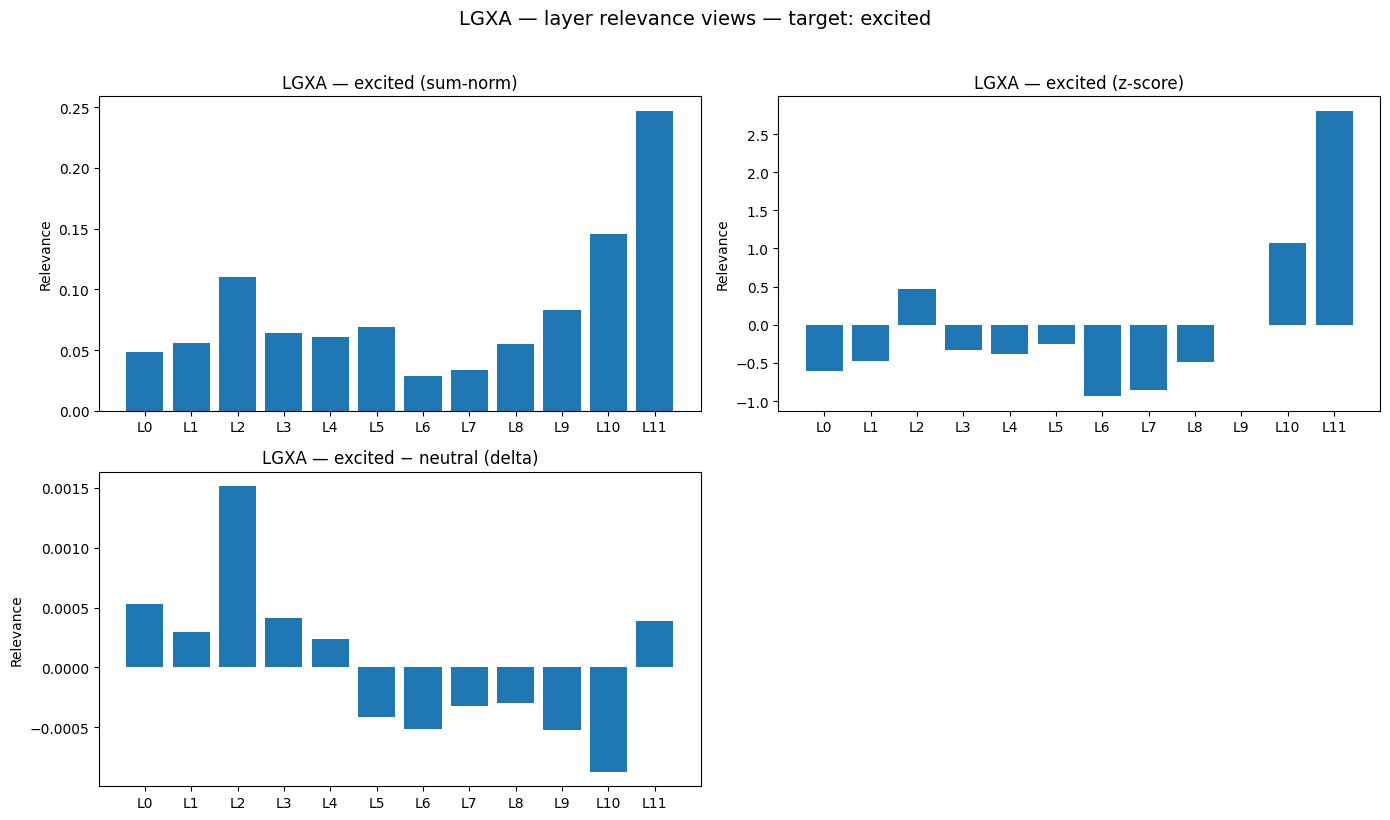

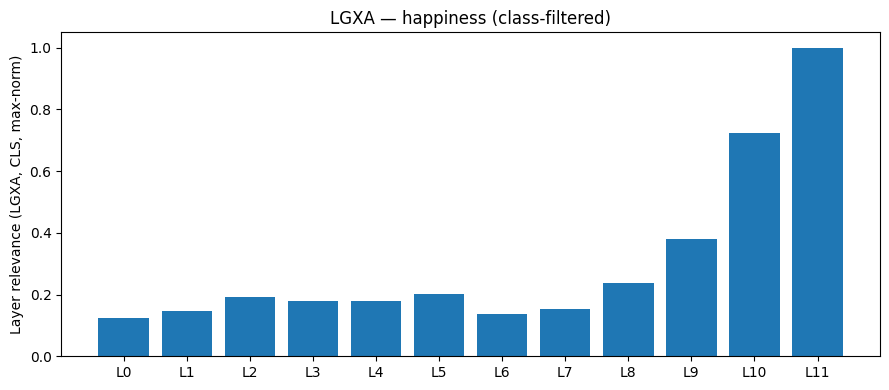

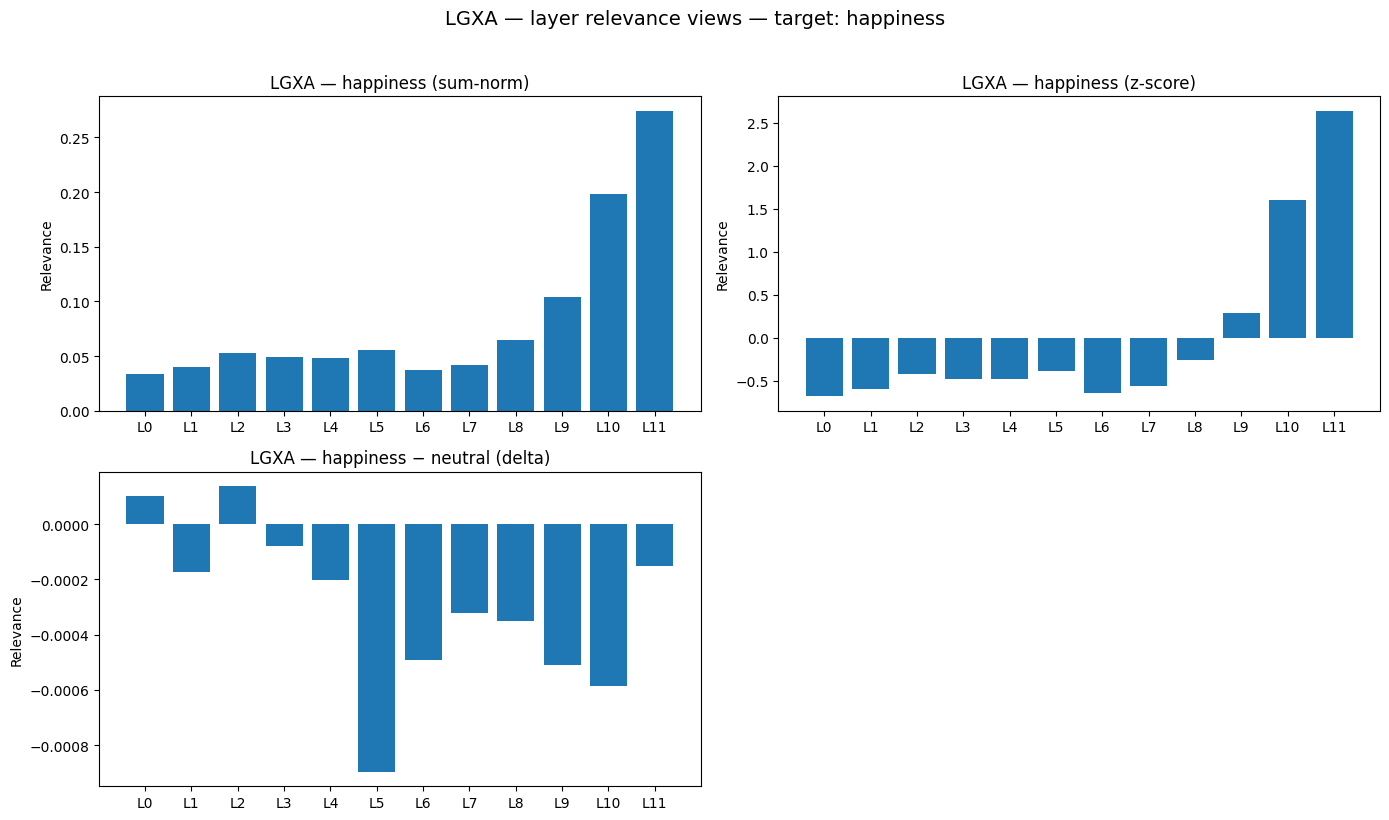

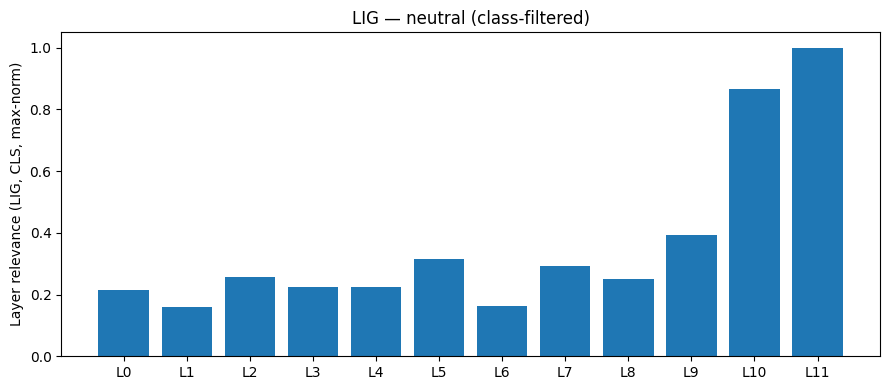

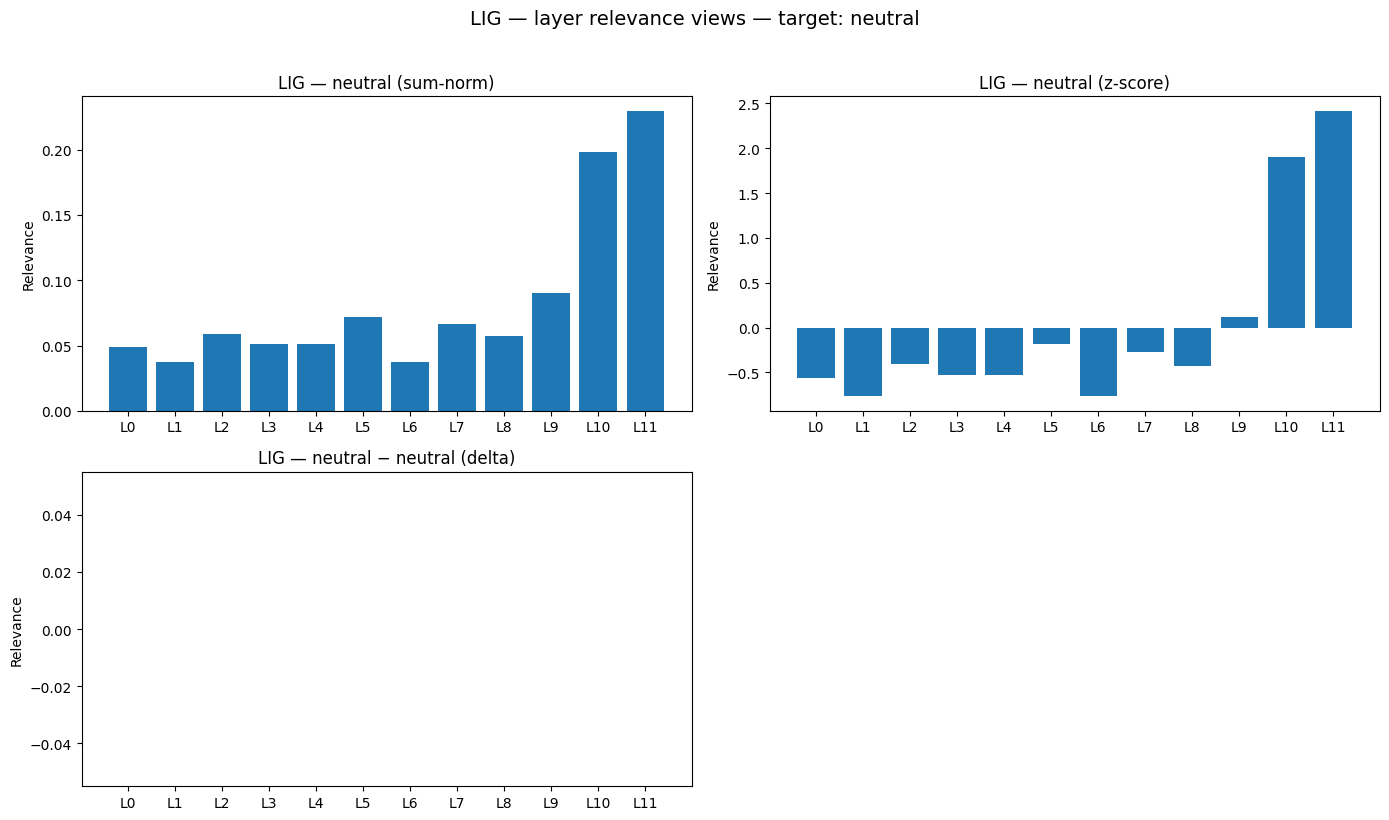

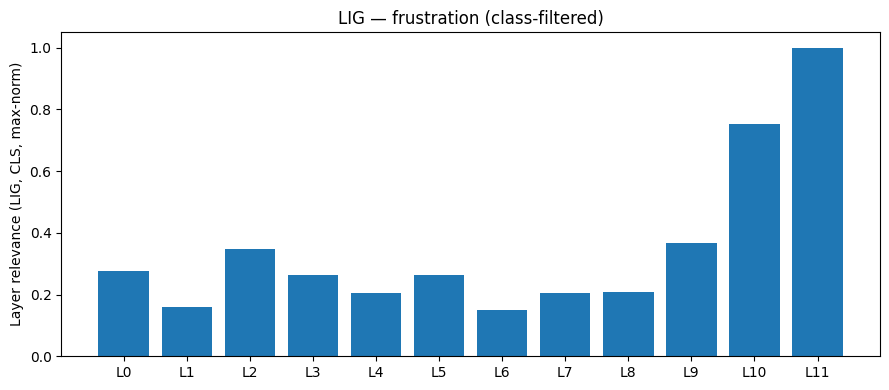

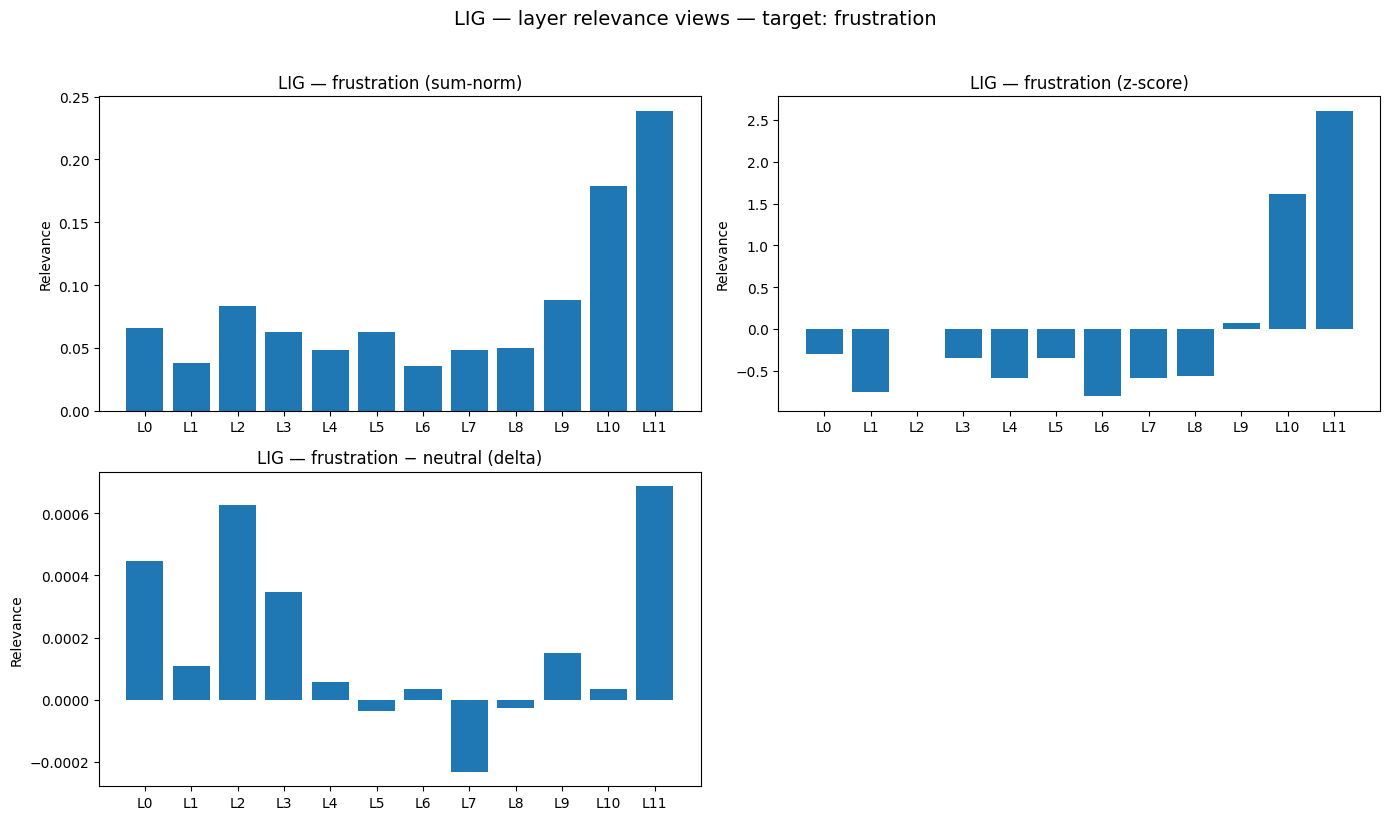

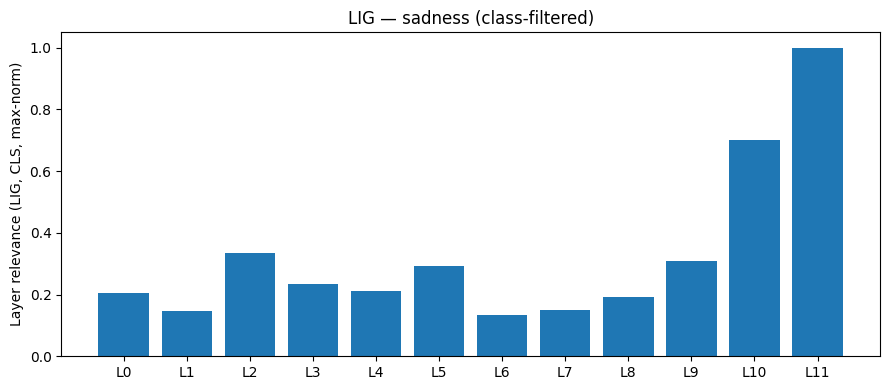

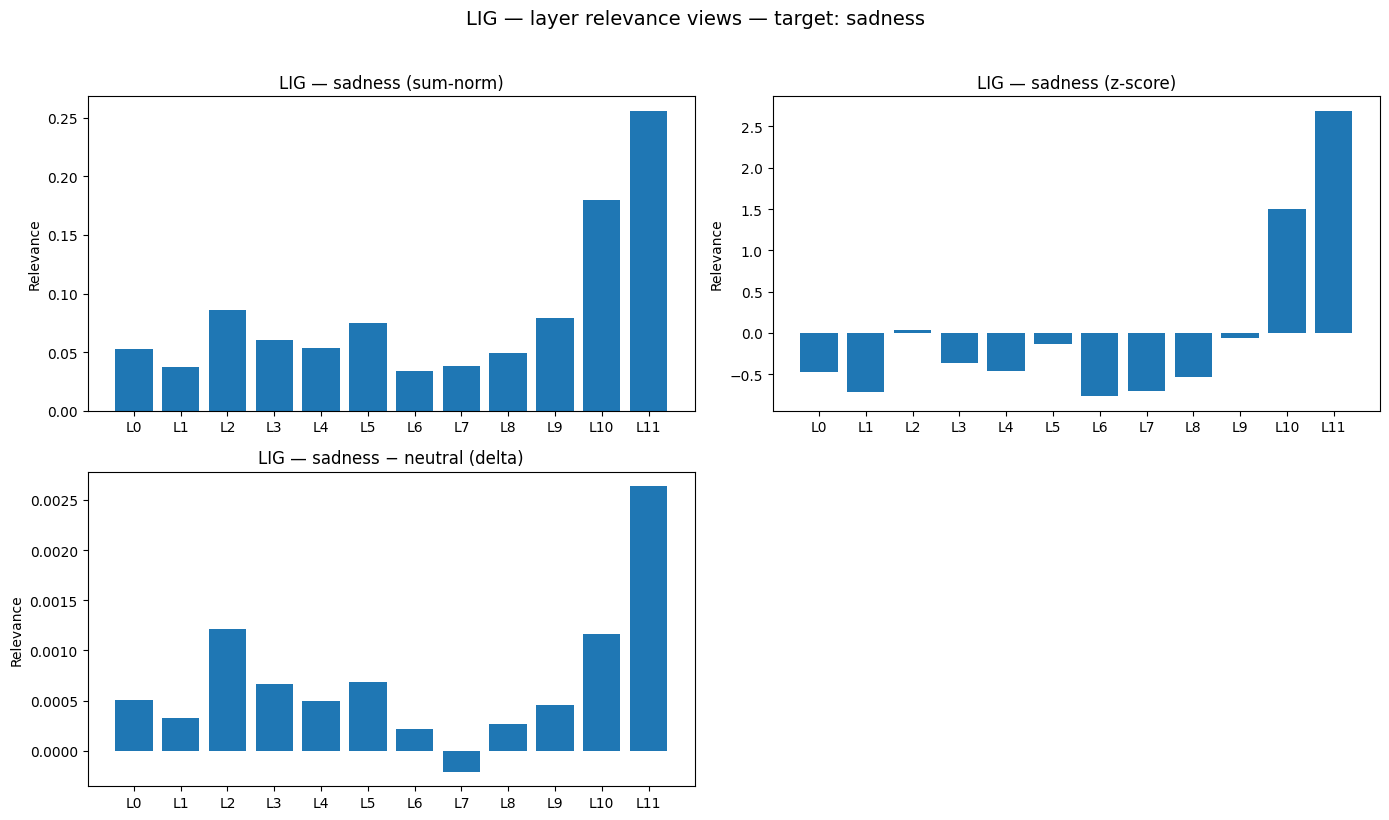

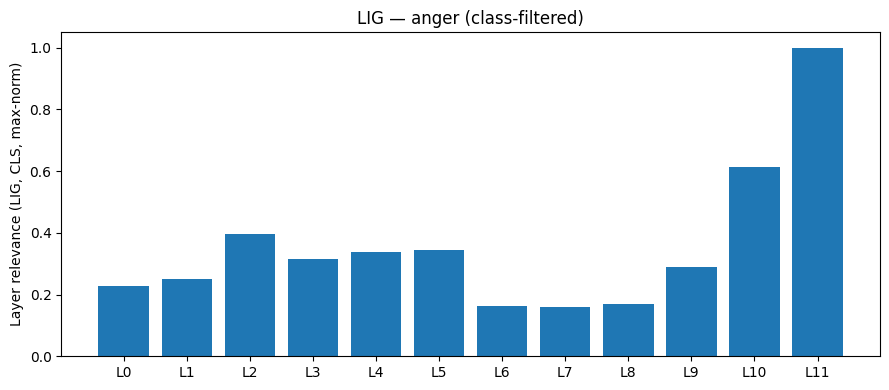

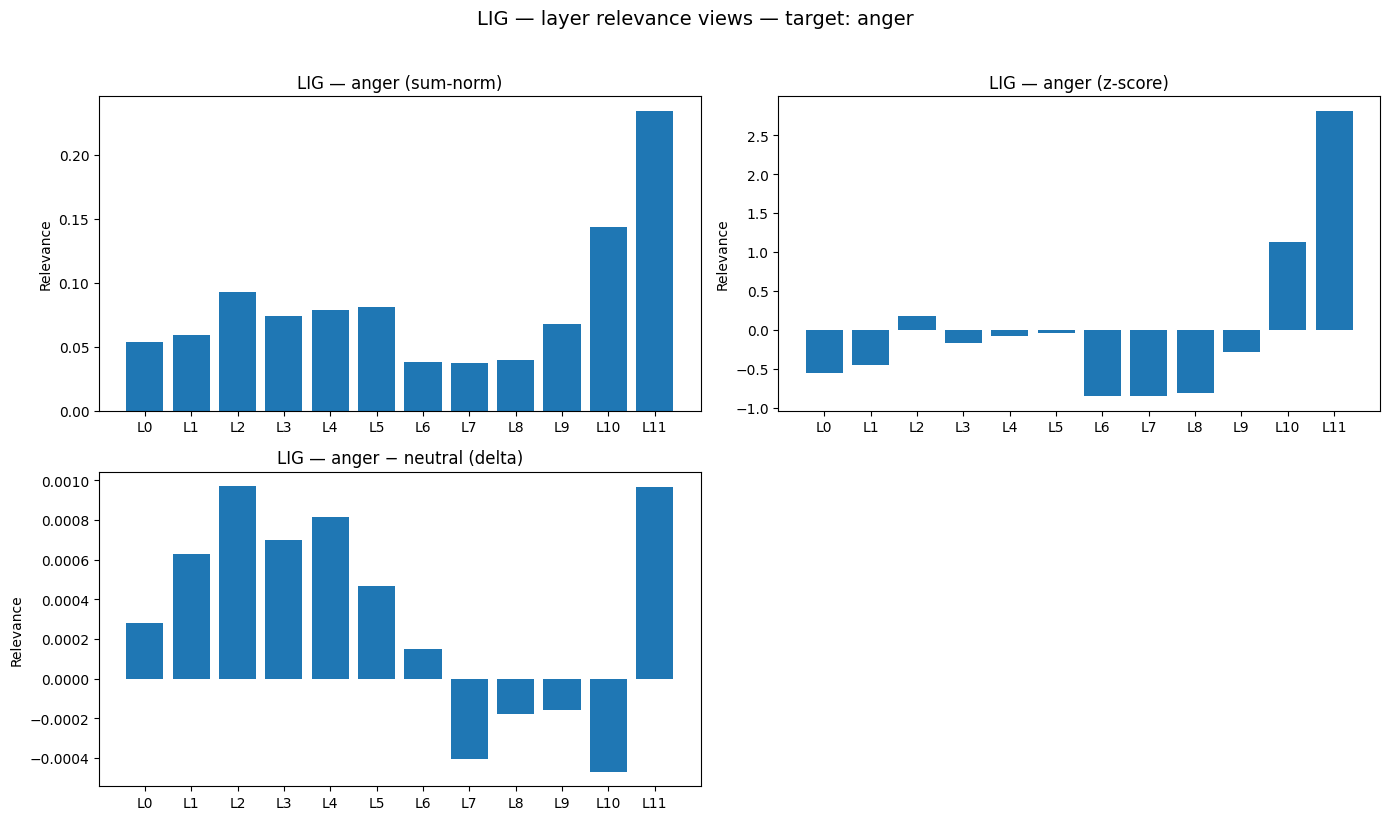

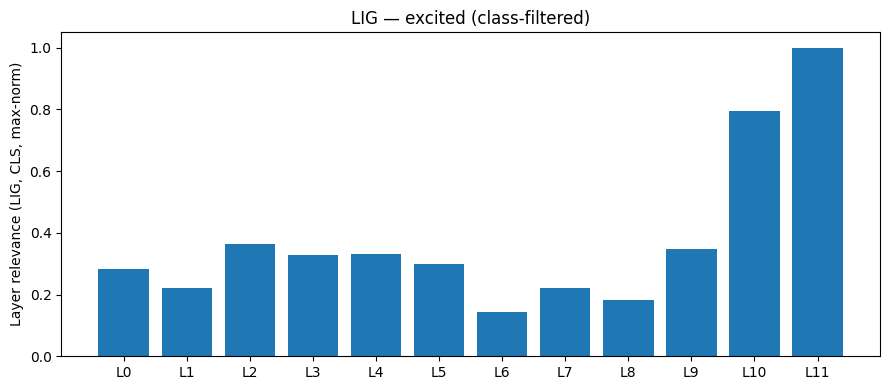

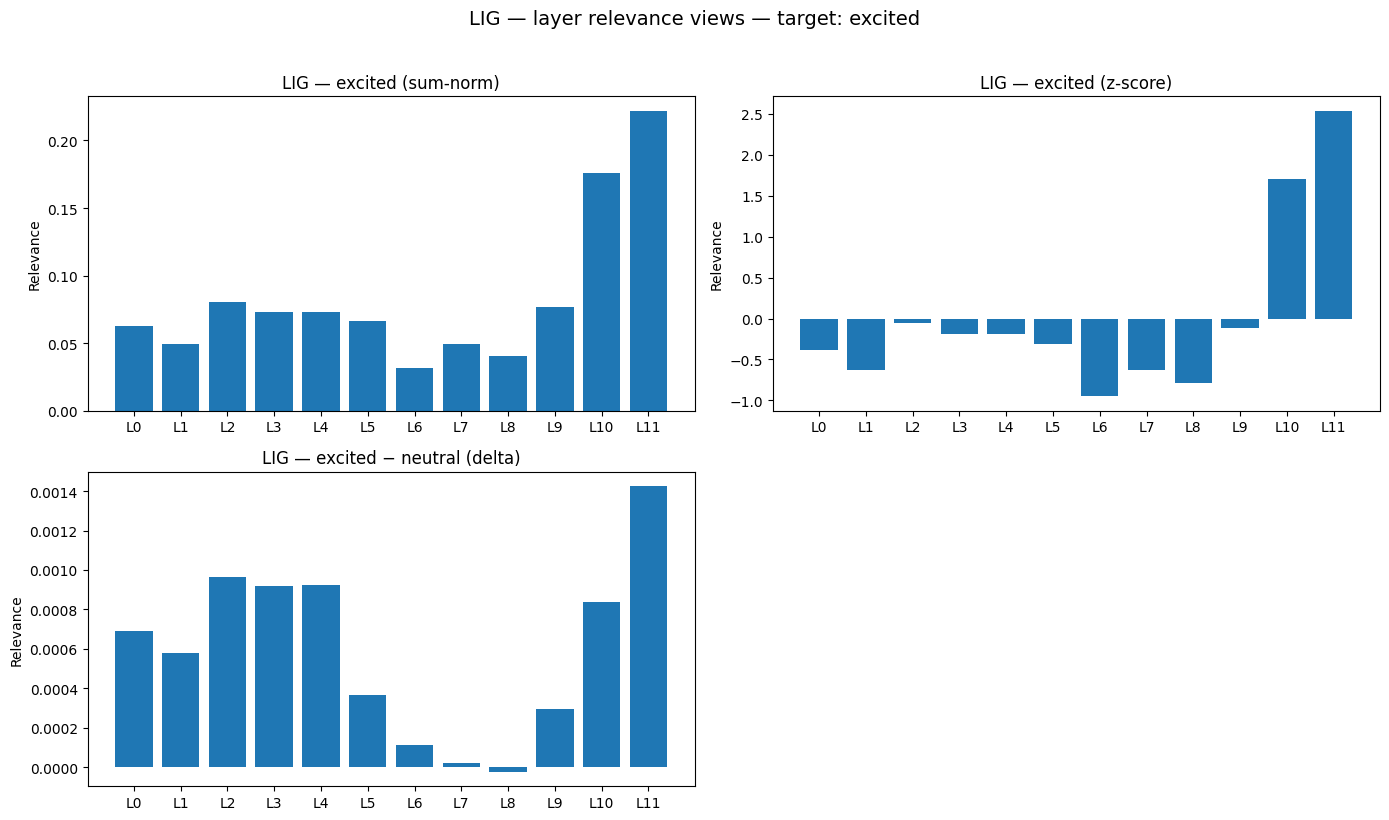

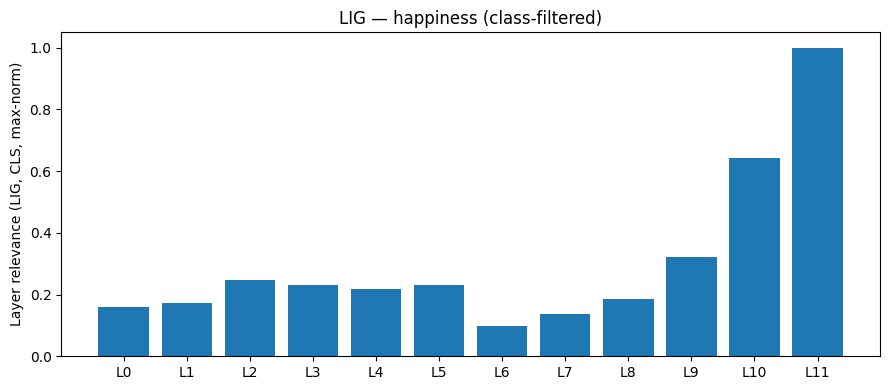

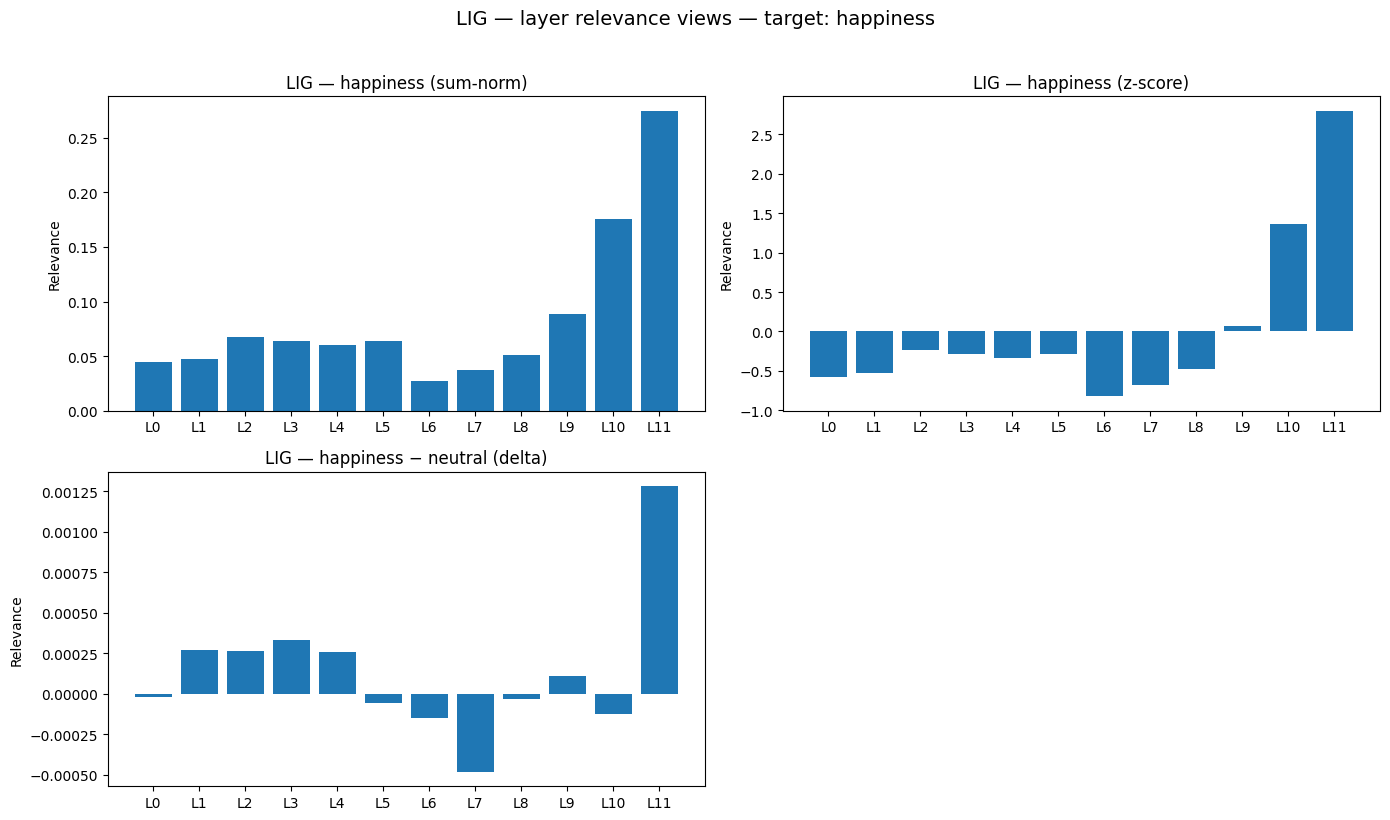

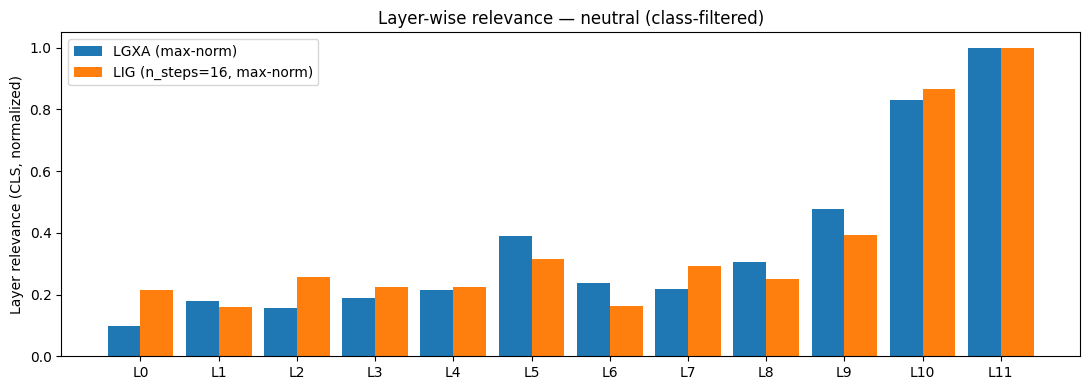

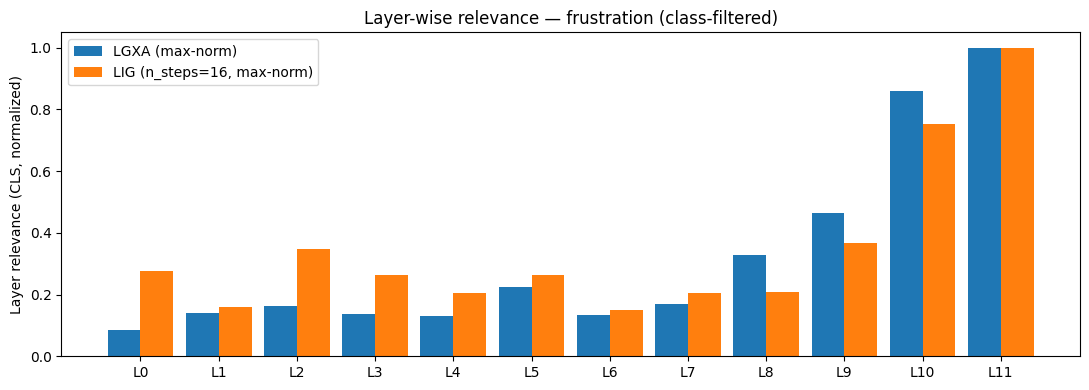

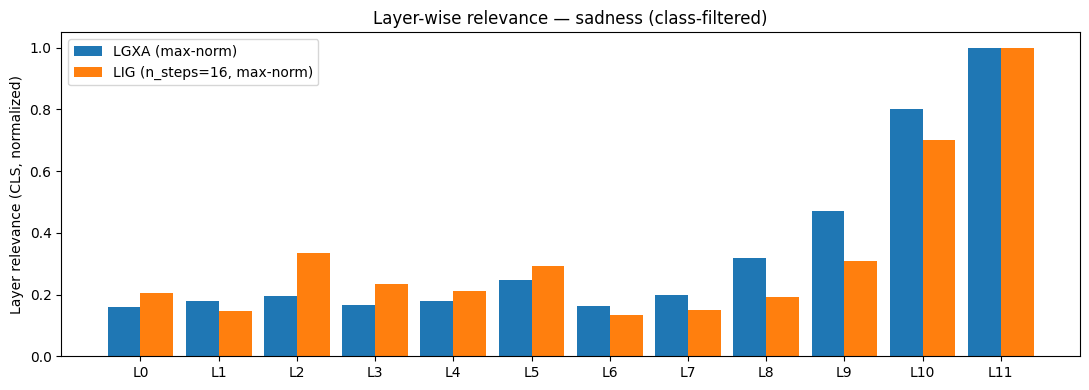

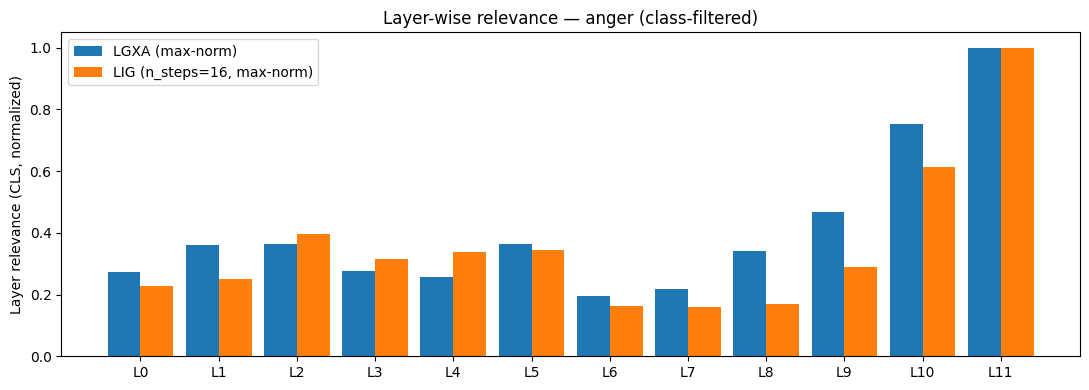

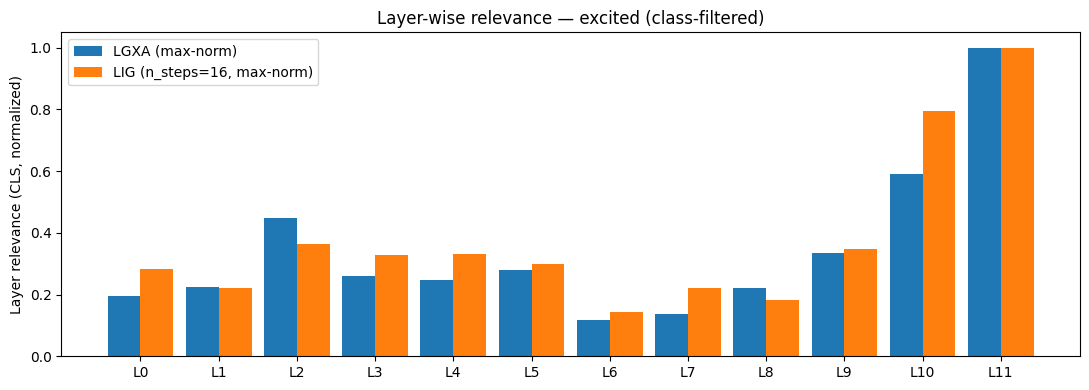

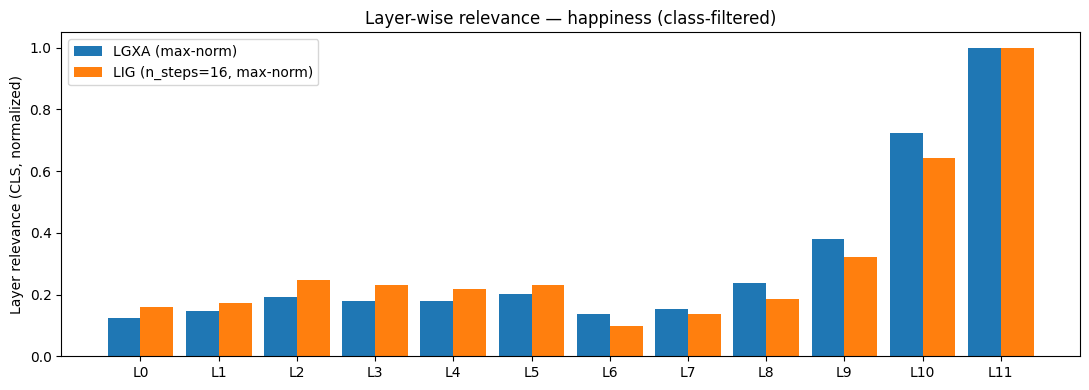


[Done] Saved plots & arrays to: plots6/lgxa_lig_layer_profiles_v2


In [ ]:
# =======================
#  Layer-wise relevance (LGXA & LIG)
# =======================

from typing import Dict, List
import torch.nn as nn
from captum.attr import LayerGradientXActivation, LayerIntegratedGradients

# ---------------- Parameters (tune for speed) ----------------
MAX_LEN = 128
BATCH_SIZE = 2
# Reduced TEXTS_SLICE and MAX_PER_CLASS to prevent OutOfMemory errors
TEXTS_SLICE = None         # None for full dataset; recommended small for speed
MAX_PER_CLASS = 30        # cap samples per predicted class
BASELINE_CLASS = "neutral"  # used for delta plots; case-insensitive
AGG_MODE = "meanabs"     # "sumabs" or "meanabs" (per-sample, over hidden dims)
LIG_STEPS = 16           # IG steps tradeoff (higher = slower but smoother)

SHOW_PLOTS = True
SAVE_PLOTS = True

# Store outputs under your global OUT_DIR
EXP_DIR = os.path.join(globals().get("OUT_DIR", "plots"), "lgxa_lig_layer_profiles_v2")
if SAVE_PLOTS:
    os.makedirs(EXP_DIR, exist_ok=True)

# ---------------- Data ----------------
TEXT_COL_LOCAL = globals().get("TEXT_COL", "Utterance")
if "df" not in globals() or TEXT_COL_LOCAL not in df.columns:
    raise ValueError(f"Expected a DataFrame `df` with text column '{TEXT_COL_LOCAL}'.")

all_texts = df[TEXT_COL_LOCAL].astype(str).tolist()
if TEXTS_SLICE is not None:
    all_texts = all_texts[:int(TEXTS_SLICE)]

# ---------------- Device / model ----------------
DEVICE_LOCAL = globals().get("DEVICE", torch.device("cuda" if torch.cuda.is_available() else "cpu"))
model.to(DEVICE_LOCAL).eval()

# ---------------- Base encoder + labels ----------------
base = getattr(model, "roberta", None) or getattr(model, "bert", None)
assert base is not None, "Expected a BERT/RoBERTa-like model with `.roberta` or `.bert`."

enc_layers = list(base.encoder.layer)
L = len(enc_layers)
layer_ticks = [f"L{i}" for i in range(L)]

id2label = getattr(model.config, "id2label", None) or {i: f"label_{i}" for i in range(model.config.num_labels)}
id2label = {int(k): v for k, v in id2label.items()}
label2id = {v.lower(): k for k, v in id2label.items()}
num_labels = len(id2label)

# ---------------- Forward wrapper: logits from embeddings ----------------
class LogitsFromEmb(nn.Module):
    def __init__(self, hf_model: nn.Module):
        super().__init__()
        self.hf_model = hf_model

    def forward(self, inputs_embeds, attention_mask):
        out = self.hf_model(inputs_embeds=inputs_embeds, attention_mask=attention_mask, return_dict=True)
        return out.logits  # (B, C)

logits_model = LogitsFromEmb(model).to(DEVICE_LOCAL).eval()
emb_layer = model.get_input_embeddings()

# ---------------- Helpers ----------------
def _batches(seq: List[str], bs: int):
    for i in range(0, len(seq), bs):
        yield seq[i:i+bs]

def _encode(batch: List[str]):
    return tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=MAX_LEN).to(DEVICE_LOCAL)

def _agg_cls_batch(attr_cls: torch.Tensor, mode: str) -> float:
    """
    attr_cls: (B, H) attributions at CLS
    Returns: sum over batch of per-sample scalar relevance (float)
    """
    x = attr_cls.abs()
    if mode == "sumabs":
        per_sample = x.sum(dim=-1)   # (B,)
    elif mode == "meanabs":
        per_sample = x.mean(dim=-1)  # (B,)
    else:
        raise ValueError("AGG_MODE must be 'sumabs' or 'meanabs'")
    return float(per_sample.sum().item())

# ----------------  Build per-class pools (predicted label pools) ----------------
texts_per_class: Dict[str, List[str]] = {id2label[i]: [] for i in range(num_labels)}

with torch.inference_mode():
    for batch in _batches(all_texts, BATCH_SIZE):
        enc = _encode(batch)
        preds = model(**enc, return_dict=True).logits.argmax(-1).detach().cpu().tolist()
        for t, p in zip(batch, preds):
            name = id2label[int(p)]
            if len(texts_per_class[name]) < MAX_PER_CLASS:
                texts_per_class[name].append(t)

for name, lst in texts_per_class.items():
    print(f"[pool] {name}: {len(lst)} samples")

# ----------------  Captum objects per layer ----------------
# We target the layer output modules; output is (B,T,H) which is what we want.
target_layers = [lyr.output for lyr in enc_layers]
lgxa_objs = [LayerGradientXActivation(logits_model, tl) for tl in target_layers]
lig_objs  = [LayerIntegratedGradients(logits_model, tl) for tl in target_layers]

# ----------------  Compute layer profiles per class ----------------
def layer_profile(texts_list: List[str], class_id: int, method: str) -> np.ndarray:
    vec = np.zeros(L, dtype=np.float64)
    n = 0

    for batch in _batches(texts_list, BATCH_SIZE):
        enc = _encode(batch)
        B = enc["input_ids"].size(0)

        # Build embeddings (B,T,D). We feed inputs_embeds into the model for stability.
        inp_emb = emb_layer(enc["input_ids"]).detach()
        am = enc["attention_mask"]

        with torch.enable_grad():
            if method == "lgxa":
                for li, lgxa in enumerate(lgxa_objs):
                    attr = lgxa.attribute(
                        inputs=inp_emb,
                        additional_forward_args=(am,),
                        target=int(class_id),
                    )  # (B, T, H)
                    vec[li] += _agg_cls_batch(attr[:, 0, :], AGG_MODE)

            elif method == "lig":
                baseline = torch.zeros_like(inp_emb)
                for li, lig in enumerate(lig_objs):
                    attr = lig.attribute(
                        inputs=inp_emb,
                        baselines=baseline,
                        additional_forward_args=(am,),
                        target=int(class_id),
                        n_steps=LIG_STEPS,
                    )  # (B, T, H)
                    vec[li] += _agg_cls_batch(attr[:, 0, :], AGG_MODE)
            else:
                raise ValueError("method must be 'lgxa' or 'lig'.")

        n += B

    return vec / max(n, 1)

raw_profiles = {"LGXA": {}, "LIG": {}}

for cid in range(num_labels):
    name = id2label[cid]
    pool = texts_per_class[name] if len(texts_per_class[name]) > 0 else all_texts

    print(f"[compute] {name}: LGXA")
    raw_profiles["LGXA"][name] = layer_profile(pool, cid, "lgxa")

    print(f"[compute] {name}: LIG")
    raw_profiles["LIG"][name] = layer_profile(pool, cid, "lig")

# ----------------  Normalizations & delta vs baseline ----------------
def norm_max(x): return x / (x.max() + 1e-12)
def norm_sum(x): return x / (x.sum() + 1e-12)
def zscore(x):   return (x - x.mean()) / (x.std() + 1e-12)

baseline_name = BASELINE_CLASS.lower()
baseline_name = baseline_name if baseline_name in label2id else list(raw_profiles["LGXA"].keys())[0]

baseline_key = next((k for k in raw_profiles["LGXA"].keys() if k.lower() == baseline_name), list(raw_profiles["LGXA"].keys())[0])
print(f"[info] baseline for delta: {baseline_key}")

for method, profs in raw_profiles.items():
    mdir = os.path.join(EXP_DIR, method)
    os.makedirs(mdir, exist_ok=True)

    for name, raw_arr in profs.items():
        nm = norm_max(raw_arr.copy())
        ns = norm_sum(raw_arr.copy())
        zz = zscore(raw_arr.copy())
        dd = raw_arr - profs[baseline_key]

        # Save arrays
        np.save(os.path.join(mdir, f"{name}_raw.npy"), raw_arr)
        np.save(os.path.join(mdir, f"{name}_normmax.npy"), nm)
        np.save(os.path.join(mdir, f"{name}_normsum.npy"), ns)
        np.save(os.path.join(mdir, f"{name}_zscore.npy"), zz)
        np.save(os.path.join(mdir, f"{name}_delta_vs_{baseline_key}.npy"), dd)

        # Plot A: max-norm
        plt.figure(figsize=(9, 4))
        plt.bar(np.arange(L), nm)
        plt.xticks(np.arange(L), layer_ticks)
        plt.ylabel(f"Layer relevance ({method}, CLS, max-norm)")
        plt.title(f"{method} — {name} (class-filtered)")
        plt.tight_layout()
        if SAVE_PLOTS:
            plt.savefig(os.path.join(mdir, f"{name}_normmax.png"), dpi=150, bbox_inches="tight")
        if SHOW_PLOTS:
            plt.show()
        plt.close()

        # Plot B: sum-norm / z-score / delta
        fig, axs = plt.subplots(2, 2, figsize=(14, 8))
        axs[0,0].bar(np.arange(L), ns); axs[0,0].set_title(f"{method} — {name} (sum-norm)")
        axs[0,1].bar(np.arange(L), zz); axs[0,1].set_title(f"{method} — {name} (z-score)")
        axs[1,0].bar(np.arange(L), dd); axs[1,0].set_title(f"{method} — {name} − {baseline_key} (delta)")
        axs[1,1].axis("off")
        for ax in axs.flat:
            ax.set_xticks(np.arange(L))
            ax.set_xticklabels(layer_ticks)
            ax.set_ylabel("Relevance")
        fig.suptitle(f"{method} — layer relevance views — target: {name}", y=1.02, fontsize=14)
        plt.tight_layout()
        if SAVE_PLOTS:
            plt.savefig(os.path.join(mdir, f"{name}_sum_z_delta.png"), dpi=150, bbox_inches="tight")
        if SHOW_PLOTS:
            plt.show()
        plt.close(fig)

# ---------------- Combined LGXA vs LIG per class (max-norm) ----------------
combo_dir = os.path.join(EXP_DIR, "COMBINED")
os.makedirs(combo_dir, exist_ok=True)

for cid in range(num_labels):
    name = id2label[cid]
    lgxa = raw_profiles["LGXA"].get(name, None)
    lig  = raw_profiles["LIG"].get(name, None)
    if lgxa is None or lig is None:
        continue

    lgxa_norm = lgxa / (lgxa.max() + 1e-12)
    lig_norm  = lig  / (lig.max()  + 1e-12)

    x = np.arange(L); width = 0.42
    plt.figure(figsize=(11, 4))
    plt.bar(x - width/2, lgxa_norm, width=width, label="LGXA (max-norm)")
    plt.bar(x + width/2, lig_norm,  width=width, label=f"LIG (n_steps={LIG_STEPS}, max-norm)")
    plt.xticks(x, layer_ticks)
    plt.ylabel("Layer relevance (CLS, normalized)")
    plt.title(f"Layer-wise relevance — {name} (class-filtered)")
    plt.legend()
    plt.tight_layout()
    if SAVE_PLOTS:
        plt.savefig(os.path.join(combo_dir, f"{name}_LGXA_vs_LIG.png"), dpi=150, bbox_inches="tight")
    if SHOW_PLOTS:
        plt.show()
    plt.close()

print(f"\n[Done] Saved plots & arrays to: {EXP_DIR}")


In [ ]:
# =======================
# 11) Logit Lens (layer trajectories)
# =======================

import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

@torch.inference_mode()
def compute_logit_lens_curve(model, tokenizer, text: str, device, target_id: int | None = None):
    """
    Returns:
      logits_per_layer: np.ndarray shape (L+1,)  (Emb + each encoder layer)
      target_id: int (class id tracked for this utterance)
      layer_names: list[str] ["Emb", "L0", ...]
    """
    enc = tokenizer(text, return_tensors="pt", truncation=True, padding=False).to(device)
    out = model(**enc, output_hidden_states=True, return_dict=True)

    final_logits = out.logits[0]  # (C,)
    if target_id is None:
        target_id = int(final_logits.argmax().item())

    # Try to locate the classifier head
    clf = getattr(model, "classifier", getattr(model, "score", None))
    if clf is None:
        raise RuntimeError("Classifier head not found (expected model.classifier or model.score).")

    def _head_forward(hidden_states_layer: torch.Tensor) -> torch.Tensor:
        """
        Compute logits from a hidden state tensor.
        Handles common HF heads:
          - RobertaClassificationHead-like: has .dense and .out_proj
          - Linear head: nn.Linear
          - Other: try clf(hidden_states_layer) then clf(CLS)
        """
        h_cls = hidden_states_layer[:, 0, :]  # (1, D)

        # RobertaClassificationHead-like (dropout disabled because model.eval())
        if hasattr(clf, "dense") and hasattr(clf, "out_proj"):
            x = torch.tanh(clf.dense(h_cls))
            return clf.out_proj(x)  # (1, C)

        # Simple linear head
        if isinstance(clf, nn.Linear):
            return clf(h_cls)  # (1, C)

        
        try:
            return clf(hidden_states_layer)
        except Exception:
            return clf(h_cls)

    logits_per_layer = []
    for H in out.hidden_states:  
        s = _head_forward(H)     
        logits_per_layer.append(float(s[0, target_id].item()))

    logits_per_layer = np.asarray(logits_per_layer, dtype=float)
    L = len(logits_per_layer) - 1
    layer_names = ["Emb"] + [f"L{i}" for i in range(L)]
    return logits_per_layer, target_id, layer_names


def compute_global_logit_lens(model, tokenizer, texts, device, max_utterances: int | None = None):
    """
    Aggregates logit-lens curves across many utterances.

    Returns:
      layer_names: list[str]
      all_curves:  np.ndarray (N, L+1)
      mean_curve:  np.ndarray (L+1,)
      std_curve:   np.ndarray (L+1,)
      target_ids:  np.ndarray (N,)
    """
    all_curves, target_ids = [], []

    for i, text in enumerate(texts):
        if max_utterances is not None and i >= max_utterances:
            break
        if not isinstance(text, str) or not text.strip():
            continue

        curve, tid, layer_names = compute_logit_lens_curve(model, tokenizer, text, device=device)
        all_curves.append(curve)
        target_ids.append(tid)

    if not all_curves:
        raise RuntimeError("No valid utterances provided for global logit-lens.")

    all_curves = np.stack(all_curves, axis=0)          
    target_ids = np.asarray(target_ids, dtype=int)     
    mean_curve = all_curves.mean(axis=0)
    std_curve  = all_curves.std(axis=0)
    return layer_names, all_curves, mean_curve, std_curve, target_ids


# ---- Run on dataset ----
device = globals().get("DEVICE", torch.device("cuda" if torch.cuda.is_available() else "cpu"))
model.to(device).eval()


text_col = globals().get("TEXT_COL", "Utterance")
if "df" in globals() and text_col in df.columns:
    texts = df[text_col].astype(str).tolist()
elif "all_texts" in globals():
    texts = list(all_texts)
else:
    raise ValueError("Provide `df` with TEXT_COL or define `all_texts` as a list of strings.")

layer_names, all_curves, mean_curve, std_curve, target_ids = compute_global_logit_lens(
    model, tokenizer, texts, device=device, max_utterances=None  # set e.g. 1000 for faster run
)

# ---- Plot mean ± std ----
x = np.arange(len(layer_names))

plt.figure(figsize=(8, 4))
plt.plot(x, mean_curve, marker="o", label="mean logit (predicted class)")
plt.fill_between(x, mean_curve - std_curve, mean_curve + std_curve, alpha=0.2, label="±1 std")
plt.xticks(x, layer_names)
plt.xlabel("Layer")
plt.ylabel("logit (per-utterance predicted class)")
plt.title("Global logit-lens profile across utterances")
plt.grid(alpha=0.2)
plt.legend()
plt.tight_layout()

base_out = globals().get("OUT_DIR", "plots")
ll_dir = os.path.join(base_out, "logit_lens")
os.makedirs(ll_dir, exist_ok=True)

fp = os.path.join(ll_dir, "global_logit_lens.png")
plt.savefig(fp, dpi=150, bbox_inches="tight")
plt.close()
print("[saved]", fp)


[saved] plots6/logit_lens/global_logit_lens.png


[t-SNE] Running on 1622 utterances.
[t-SNE] Embeddings: (1622, 768)
[t-SNE] Running PCA -> t-SNE ...


Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7cba509e2ac0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.12/dist-packages/threadpoolctl.py", line 1187, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/ctypes/__init__.py", line 379, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: /usr/local/lib/python3.12/dist-packages/numpy.libs/libopenblas64_p-r0-0cf96a72

[saved] plots6/tsne_cls_gold.png


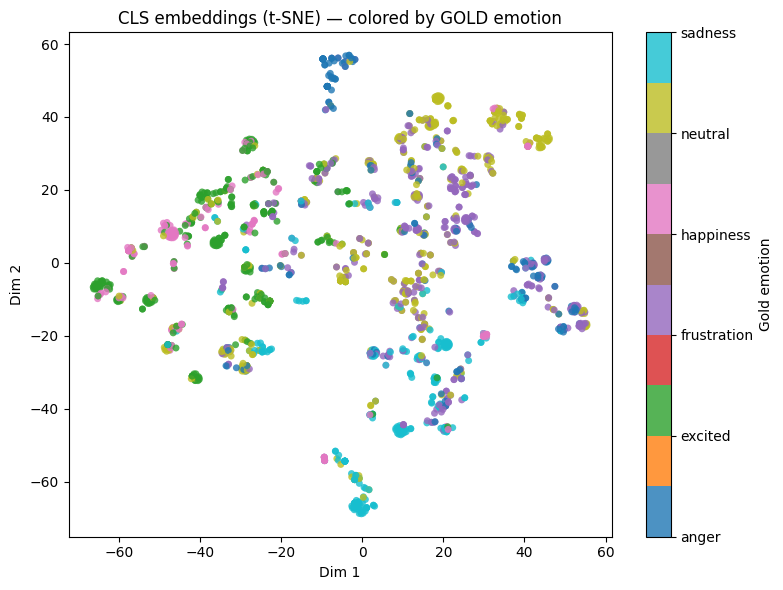

[saved] plots6/tsne_cls_misclassified.png


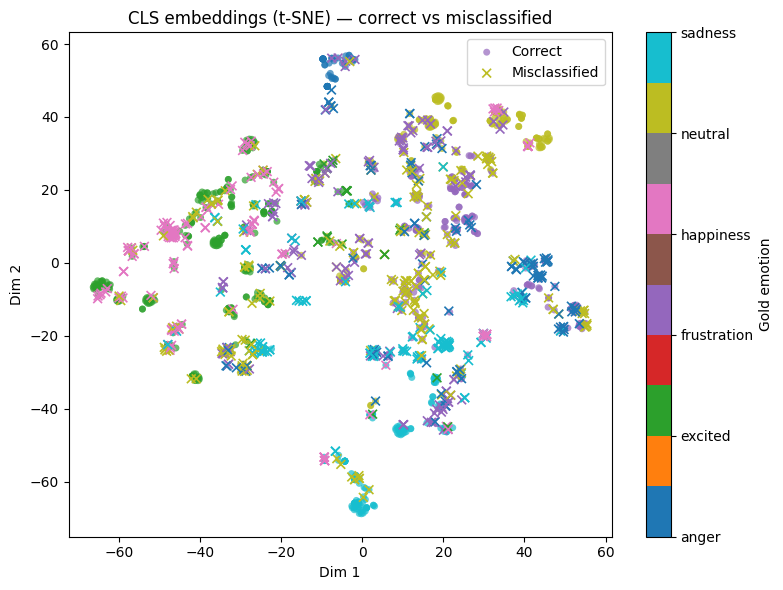

In [ ]:
# =======================
#  CLS embeddings — t-SNE
# =======================


import os
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# ---- Parameters ----
MAX_TSNE_UTTERANCES = 3000   # 10k can be very slow; increase gradually if needed
BATCH_SIZE = 32
MAX_LEN = 128
PERPLEXITY = 30
RANDOM_STATE_SAMPLE = 42
RANDOM_STATE_TSNE = 24

SAVE_PLOTS = True
SHOW_PLOTS = True

assert "df" in globals(), "Expected a DataFrame `df` loaded from your CSV."
assert TEXT_COL in df.columns, f"Missing TEXT_COL='{TEXT_COL}' in df.columns"
assert LABEL_COL in df.columns, f"Missing LABEL_COL='{LABEL_COL}' in df.columns"

if SAVE_PLOTS:
    os.makedirs(OUT_DIR, exist_ok=True)

# ---- Subsample for speed ----
if len(df) > MAX_TSNE_UTTERANCES:
    df_tsne = df.sample(n=MAX_TSNE_UTTERANCES, random_state=RANDOM_STATE_SAMPLE).reset_index(drop=True)
else:
    df_tsne = df.reset_index(drop=True)

texts = df_tsne[TEXT_COL].astype(str).tolist()
y_gold = df_tsne[LABEL_COL].astype(str).to_numpy()

print(f"[t-SNE] Running on {len(df_tsne)} utterances.")

# ---- Extract CLS embeddings + predictions ----
model.to(DEVICE).eval()
id2label = model.config.id2label

cls_chunks = []
pred_labels = []

with torch.inference_mode():
    for i in range(0, len(texts), BATCH_SIZE):
        batch_texts = texts[i:i + BATCH_SIZE]

        enc = tokenizer(
            batch_texts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=MAX_LEN
        ).to(DEVICE)

        out = model(**enc, output_hidden_states=True, return_dict=True)
        logits = out.logits                              # (B, C)
        hidden_states = out.hidden_states                # list[(B, T, D)]

        cls_last = hidden_states[-1][:, 0, :]           # (B, D) CLS from last layer
        cls_chunks.append(cls_last.detach().cpu().numpy())

        pred_idx = logits.argmax(dim=-1).detach().cpu().numpy().tolist()
        pred_labels.extend([id2label[int(j)] for j in pred_idx])

X_sent = np.vstack(cls_chunks)               # (N, D)
y_pred = np.array(pred_labels, dtype=object) # (N,)

print("[t-SNE] Embeddings:", X_sent.shape)

# ---- PCA -> t-SNE ----
print("[t-SNE] Running PCA -> t-SNE ...")
X50 = PCA(n_components=min(50, X_sent.shape[1]), random_state=RANDOM_STATE_SAMPLE).fit_transform(X_sent)

tsne = TSNE(
    n_components=2,
    init="pca",
    learning_rate="auto",
    perplexity=PERPLEXITY,
    random_state=RANDOM_STATE_TSNE
)
coords = tsne.fit_transform(X50)  # (N, 2)

# Color mapping based on labels present in the sampled subset
emotions = sorted(pd.unique(y_gold).tolist())
e2i = {e: i for i, e in enumerate(emotions)}

# ---- Plot 1: colored by GOLD label ----
plt.figure(figsize=(8, 6))
plt.scatter(
    coords[:, 0], coords[:, 1],
    c=[e2i[e] for e in y_gold],
    cmap="tab10", alpha=0.8, s=25, edgecolors="none"
)
plt.title("CLS embeddings (t-SNE) — colored by GOLD emotion")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
cbar = plt.colorbar(ticks=range(len(emotions)))
cbar.ax.set_yticklabels(emotions)
cbar.set_label("Gold emotion")
plt.tight_layout()

if SAVE_PLOTS:
    fp1 = os.path.join(OUT_DIR, "tsne_cls_gold.png")
    plt.savefig(fp1, dpi=150, bbox_inches="tight")
    print("[saved]", fp1)

if SHOW_PLOTS:
    plt.show()
plt.close()

# ---- Plot 2: correct vs misclassified ----
mis_mask = (y_gold != y_pred)

plt.figure(figsize=(8, 6))
plt.scatter(
    coords[~mis_mask, 0], coords[~mis_mask, 1],
    c=[e2i[e] for e in y_gold[~mis_mask]],
    cmap="tab10", alpha=0.7, s=25, edgecolors="none",
    label="Correct"
)
plt.scatter(
    coords[mis_mask, 0], coords[mis_mask, 1],
    c=[e2i[e] for e in y_gold[mis_mask]],
    cmap="tab10", alpha=1.0, s=40, marker="x", linewidths=1.2,
    label="Misclassified"
)
plt.title("CLS embeddings (t-SNE) — correct vs misclassified")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.legend(loc="best")
cbar = plt.colorbar(ticks=range(len(emotions)))
cbar.ax.set_yticklabels(emotions)
cbar.set_label("Gold emotion")
plt.tight_layout()

if SAVE_PLOTS:
    fp2 = os.path.join(OUT_DIR, "tsne_cls_misclassified.png")
    plt.savefig(fp2, dpi=150, bbox_inches="tight")
    print("[saved]", fp2)

if SHOW_PLOTS:
    plt.show()
plt.close()


In [ ]:
# =======================
#  Cluster metrics (CLS space)
# =======================

import os
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.spatial.distance import cdist

# ---- Settings ----
SAVE_PLOTS = True
SHOW_PLOTS = True
FIG_DPI = 150

# ---- Sanity checks (depends on previous cells) ----
required = ["X_sent", "y_gold", "coords"]
missing = [k for k in required if k not in globals()]
if missing:
    raise ValueError(f"Missing required variables from previous steps: {missing}. "
                     "Run the CLS embedding + t-SNE cell first.")

if "OUT_DIR" not in globals():
    OUT_DIR = "plots"
if SAVE_PLOTS:
    os.makedirs(OUT_DIR, exist_ok=True)

# If emotions/e2i are not defined, derive them from y_gold
if "emotions" in globals() and isinstance(emotions, (list, tuple)) and len(emotions) > 0:
    labels_order = list(emotions)
else:
    labels_order = sorted(pd.unique(y_gold).tolist())

if "e2i" not in globals():
    e2i = {e: i for i, e in enumerate(labels_order)}

# ---- Helper: centroids + intra distances in any space ----
def cluster_stats(X, y, labels_order=None):
    """
    X: (N, D) features (e.g., CLS embeddings or 2D t-SNE coords)
    y: (N,) label array (strings)
    labels_order: ordered list of labels to keep consistent plotting
    """
    if labels_order is None:
        labels_order = sorted(pd.unique(y).tolist())

    centroids = {}
    intra_mean, intra_median, intra_p95, intra_max = {}, {}, {}, {}
    counts = {}

    for lab in labels_order:
        mask = (y == lab)
        Xc = X[mask]
        if Xc.shape[0] == 0:
            centroids[lab] = np.full((X.shape[1],), np.nan)
            intra_mean[lab] = intra_median[lab] = intra_p95[lab] = intra_max[lab] = np.nan
            counts[lab] = 0
            continue

        c = Xc.mean(axis=0)
        centroids[lab] = c

        d = np.linalg.norm(Xc - c, axis=1)
        intra_mean[lab]   = float(d.mean())
        intra_median[lab] = float(np.median(d))
        intra_p95[lab]    = float(np.percentile(d, 95))
        intra_max[lab]    = float(d.max())
        counts[lab]       = int(Xc.shape[0])

    # Inter-centroid distances (K x K)
    C = np.stack([centroids[lab] for lab in labels_order], axis=0)
    inter = cdist(C, C, metric="euclidean")

    # Nearest-neighbor centroid distance per class (ignore diagonal)
    outer_nn = {}
    for i, lab in enumerate(labels_order):
        row = inter[i].copy()
        row[i] = np.inf
        outer_nn[lab] = float(np.nanmin(row)) if np.isfinite(row).any() else np.nan

    return {
        "labels": labels_order,
        "centroids": centroids,
        "inter_matrix": inter,
        "outer_nn": outer_nn,
        "intra_mean": intra_mean,
        "intra_median": intra_median,
        "intra_p95": intra_p95,
        "intra_max": intra_max,
        "counts": counts,
    }

# ---- Metrics computed in CLS space (best for distances) ----
valid_mask = ~np.isnan(X_sent).any(axis=1)
Xs_valid = X_sent[valid_mask]
yg_valid = y_gold[valid_mask]

stats_cls = cluster_stats(Xs_valid, yg_valid, labels_order=labels_order)

if len(pd.unique(yg_valid)) >= 2:
    sil = float(silhouette_score(Xs_valid, yg_valid))
    dbi = float(davies_bouldin_score(Xs_valid, yg_valid))
    ch  = float(calinski_harabasz_score(Xs_valid, yg_valid))
else:
    sil = dbi = ch = np.nan

# Dunn index (simple proxy): min off-diagonal inter-centroid / max intra radius
try:
    M = stats_cls["inter_matrix"].copy()
    np.fill_diagonal(M, np.inf)
    inter_min = float(np.nanmin(M))
    intra_max = float(np.nanmax([stats_cls["intra_max"][lab] for lab in labels_order]))
    dunn = float(inter_min / (intra_max + 1e-12))
except Exception:
    dunn = np.nan

print("\n=== Cluster validity (CLS embeddings) ===")
print(f"Silhouette (↑):          {sil:.4f}")
print(f"Davies–Bouldin (↓):      {dbi:.4f}")
print(f"Calinski–Harabasz (↑):   {ch:.2f}")
print(f"Dunn index (↑):          {dunn:.4f}")

# ---- 1) Heatmap: inter-centroid distances (CLS) ----
plt.figure(figsize=(7, 6))
M = stats_cls["inter_matrix"]
im = plt.imshow(M, cmap="viridis")
plt.colorbar(label="Centroid distance (CLS space)")
plt.xticks(range(len(labels_order)), labels_order, rotation=45, ha="right")
plt.yticks(range(len(labels_order)), labels_order)
plt.title("Inter-cluster centroid distances (CLS)")

K = len(labels_order)
M_mean = np.nanmean(M)
for i in range(K):
    for j in range(K):
        val = M[i, j]
        if not np.isfinite(val):
            continue
        txt = f"{val:.1f}"
        color = "white" if val > M_mean else "black"
        plt.text(j, i, txt, ha="center", va="center", color=color, fontsize=8)

plt.tight_layout()
if SAVE_PLOTS:
    fp = os.path.join(OUT_DIR, "cluster_inter_centroid_heatmap_cls.png")
    plt.savefig(fp, dpi=FIG_DPI, bbox_inches="tight")
    print("[saved]", fp)
if SHOW_PLOTS:
    plt.show()
plt.close()

# ---- 2) Bar plot: intra-cluster radius (95th percentile) in CLS space ----
vals = [stats_cls["intra_p95"][lab] for lab in labels_order]
plt.figure(figsize=(8, 4))
plt.bar(np.arange(len(labels_order)), vals)
plt.xticks(range(len(labels_order)), labels_order, rotation=45, ha="right")
plt.ylabel("Intra radius (95th pct dist-to-centroid)")
plt.title("Intra-cluster compactness per class (CLS embeddings)")
plt.tight_layout()
if SAVE_PLOTS:
    fp = os.path.join(OUT_DIR, "cluster_intra_radius_p95_cls.png")
    plt.savefig(fp, dpi=FIG_DPI, bbox_inches="tight")
    print("[saved]", fp)
if SHOW_PLOTS:
    plt.show()
plt.close()

# ---- 3) t-SNE overlay: centroids + 95th pct circles (computed in t-SNE space for visuals) ----
stats_tsne = cluster_stats(coords, y_gold, labels_order=labels_order)

plt.figure(figsize=(8, 6))
plt.scatter(
    coords[:, 0], coords[:, 1],
    c=[e2i[e] for e in y_gold],
    cmap="tab10",
    alpha=0.25,
    s=10,
    edgecolors="none"
)

for lab in labels_order:
    c = stats_tsne["centroids"][lab]
    if np.any(np.isnan(c)):
        continue

    plt.scatter(c[0], c[1], marker="*", s=220, edgecolor="k", linewidth=0.8)
    r = stats_tsne["intra_p95"][lab]
    circ = plt.Circle((c[0], c[1]), r, fill=False, linestyle="--", linewidth=1.2, alpha=0.9)
    plt.gca().add_patch(circ)

    # Annotate nearest centroid distance in CLS space (more meaningful than t-SNE distances)
    nn = stats_cls["outer_nn"][lab]
    plt.text(c[0], c[1], f"{lab}\nNN={nn:.2f}", ha="center", va="top", fontsize=9)

plt.title("t-SNE with centroids (★) + 95th-pct radius per class")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.tight_layout()
if SAVE_PLOTS:
    fp = os.path.join(OUT_DIR, "tsne_centroids_radii.png")
    plt.savefig(fp, dpi=FIG_DPI, bbox_inches="tight")
    print("[saved]", fp)
if SHOW_PLOTS:
    plt.show()
plt.close()



[RoBERTa t-SNE] Using 1650 utterances | model=roberta-base


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[RoBERTa t-SNE] Embeddings: (1650, 768)
[saved] plots/tsne_cls_roberta_base_gold.png


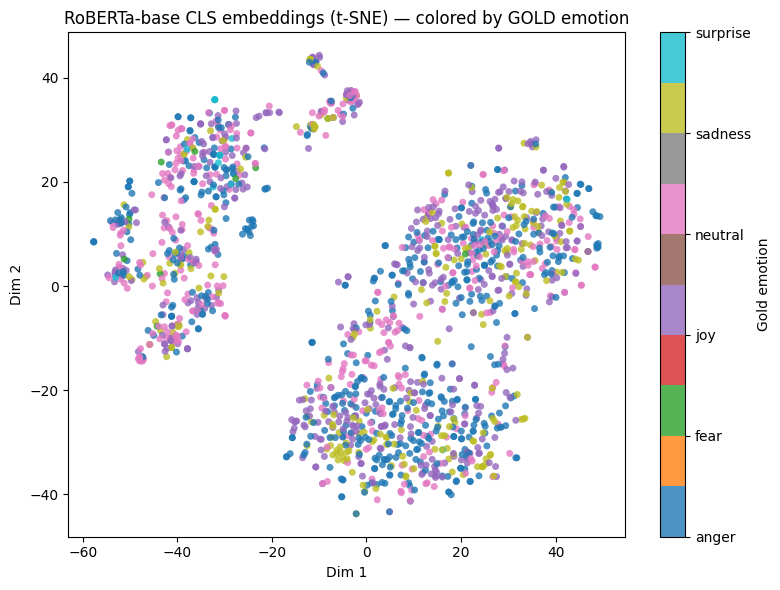

In [ ]:
# =======================
#  RoBERTa-base baseline — t-SNE
# =======================


from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from transformers import AutoTokenizer, AutoModel
import os

# ---- Config ----
MODEL_NAME = "roberta-base"
MAX_TSNE_UTTERANCES = 3000   
BATCH_SIZE = 32
MAX_LEN = 128
PERPLEXITY = 30
RANDOM_STATE_SAMPLE = 42
RANDOM_STATE_TSNE = 24

SAVE_PLOTS = True
SHOW_PLOTS = True

assert "df" in globals(), "Expected a DataFrame `df` loaded from your CSV."
assert TEXT_COL in df.columns, f"Missing TEXT_COL='{TEXT_COL}' in df.columns"
assert LABEL_COL in df.columns, f"Missing LABEL_COL='{LABEL_COL}' in df.columns"

if SAVE_PLOTS:
    os.makedirs(OUT_DIR, exist_ok=True)

# ---- Subsample for speed ----
if len(df) > MAX_TSNE_UTTERANCES:
    df_tsne = df.sample(n=MAX_TSNE_UTTERANCES, random_state=RANDOM_STATE_SAMPLE).reset_index(drop=True)
else:
    df_tsne = df.reset_index(drop=True)

texts = df_tsne[TEXT_COL].astype(str).tolist()
y_gold = df_tsne[LABEL_COL].astype(str).to_numpy()

print(f"[RoBERTa t-SNE] Using {len(texts)} utterances | model={MODEL_NAME}")

# ---- Load baseline RoBERTa encoder ----
tok_base = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
enc_base = AutoModel.from_pretrained(MODEL_NAME, output_hidden_states=True, return_dict=True).to(DEVICE).eval()

# ---- Extract CLS embeddings (last layer) ----
cls_chunks = []
with torch.inference_mode():
    for i in range(0, len(texts), BATCH_SIZE):
        batch = texts[i:i + BATCH_SIZE]
        enc = tok_base(
            batch,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=MAX_LEN
        ).to(DEVICE)

        out = enc_base(**enc)
        cls_last = out.hidden_states[-1][:, 0, :]  # (B, D)
        cls_chunks.append(cls_last.detach().cpu().numpy())

X_sent_base = np.vstack(cls_chunks)
print("[RoBERTa t-SNE] Embeddings:", X_sent_base.shape)

# ---- PCA -> t-SNE ----
X50 = PCA(n_components=min(50, X_sent_base.shape[1]), random_state=RANDOM_STATE_SAMPLE).fit_transform(X_sent_base)

coords_base = TSNE(
    n_components=2,
    init="pca",
    learning_rate="auto",
    perplexity=PERPLEXITY,
    random_state=RANDOM_STATE_TSNE
).fit_transform(X50)

# ---- Color mapping from sampled labels ----
emotions = sorted(pd.unique(y_gold).tolist())
e2i = {e: i for i, e in enumerate(emotions)}

# ---- Plot ----
plt.figure(figsize=(8, 6))
plt.scatter(
    coords_base[:, 0], coords_base[:, 1],
    c=[e2i[e] for e in y_gold],
    cmap="tab10",
    alpha=0.8,
    s=25,
    edgecolors="none"
)
plt.title("RoBERTa-base CLS embeddings (t-SNE) — colored by GOLD emotion")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")

cbar = plt.colorbar(ticks=range(len(emotions)))
cbar.ax.set_yticklabels(emotions)
cbar.set_label("Gold emotion")

plt.tight_layout()

if SAVE_PLOTS:
    fp = os.path.join(OUT_DIR, "tsne_cls_roberta_base_gold.png")
    plt.savefig(fp, dpi=150, bbox_inches="tight")
    print("[saved]", fp)

if SHOW_PLOTS:
    plt.show()
plt.close()



=== Cluster validity (CLS embeddings) — roberta_base ===
Silhouette (↑):          -0.1343
Davies–Bouldin (↓):      9.3669
Calinski–Harabasz (↑):   8.54
Dunn index (↑):          0.0684
[saved] plots/roberta_base_cluster_inter_centroid_heatmap_cls.png


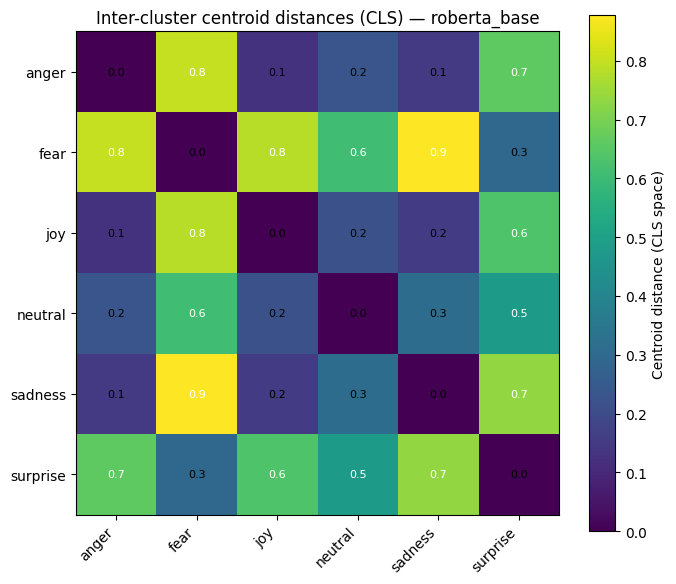

[saved] plots/roberta_base_cluster_intra_radius_p95_cls.png


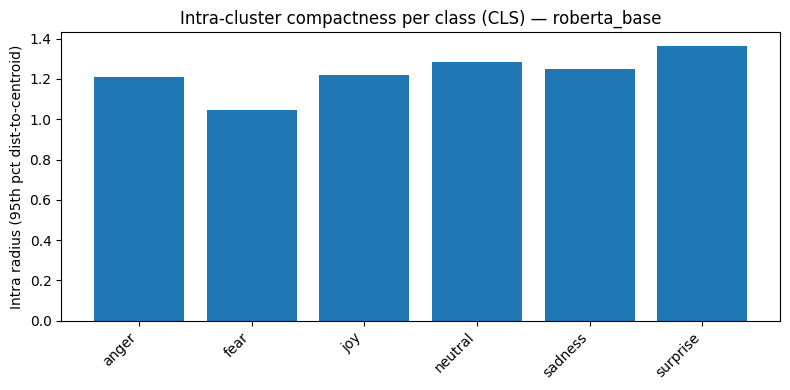

[saved] plots/roberta_base_tsne_centroids_radii.png


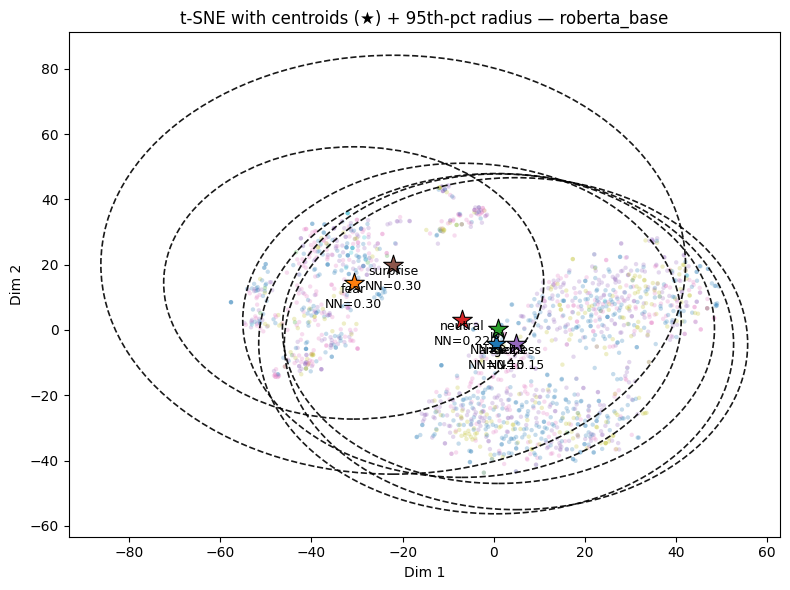

In [ ]:
# =======================
# 15) RoBERTa-base baseline — cluster metrics
# =======================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.spatial.distance import cdist

# ---- Inputs (from previous RoBERTa t-SNE cell) ----
required = ["X_sent_base", "coords_base", "y_gold"]
missing = [k for k in required if k not in globals()]
if missing:
    raise ValueError(f"Missing required variables: {missing}. Run the RoBERTa CLS t-SNE cell first.")

X_sent = X_sent_base
coords = coords_base

# ---- Settings ----
SAVE_PLOTS = True
SHOW_PLOTS = True
FIG_DPI = 150
PREFIX = "roberta_base"  # used in filenames to avoid overwriting other runs

if "OUT_DIR" not in globals():
    OUT_DIR = "plots"
if SAVE_PLOTS:
    os.makedirs(OUT_DIR, exist_ok=True)

# Label order + color mapping 
labels_order = sorted(pd.unique(y_gold).tolist())
e2i = {e: i for i, e in enumerate(labels_order)}

# ---- Helper: centroids + intra distances in any space ----
def cluster_stats(X, y, labels_order):
    centroids = {}
    intra_mean, intra_median, intra_p95, intra_max = {}, {}, {}, {}
    counts = {}

    for lab in labels_order:
        mask = (y == lab)
        Xc = X[mask]
        if Xc.shape[0] == 0:
            centroids[lab] = np.full((X.shape[1],), np.nan)
            intra_mean[lab] = intra_median[lab] = intra_p95[lab] = intra_max[lab] = np.nan
            counts[lab] = 0
            continue

        c = Xc.mean(axis=0)
        centroids[lab] = c
        d = np.linalg.norm(Xc - c, axis=1)

        intra_mean[lab]   = float(d.mean())
        intra_median[lab] = float(np.median(d))
        intra_p95[lab]    = float(np.percentile(d, 95))
        intra_max[lab]    = float(d.max())
        counts[lab]       = int(Xc.shape[0])

    C = np.stack([centroids[lab] for lab in labels_order], axis=0)
    inter = cdist(C, C, metric="euclidean")

    outer_nn = {}
    for i, lab in enumerate(labels_order):
        row = inter[i].copy()
        row[i] = np.inf
        outer_nn[lab] = float(np.nanmin(row)) if np.isfinite(row).any() else np.nan

    return {
        "labels": labels_order,
        "centroids": centroids,
        "inter_matrix": inter,
        "outer_nn": outer_nn,
        "intra_mean": intra_mean,
        "intra_median": intra_median,
        "intra_p95": intra_p95,
        "intra_max": intra_max,
        "counts": counts,
    }

# ---- Metrics computed in CLS space (best for distances) ----
valid_mask = ~np.isnan(X_sent).any(axis=1)
Xs_valid = X_sent[valid_mask]
yg_valid = np.asarray(y_gold)[valid_mask]

stats_cls = cluster_stats(Xs_valid, yg_valid, labels_order=labels_order)

# Some metrics can fail if a label has <2 samples; handle safely
sil = dbi = ch = np.nan
if len(pd.unique(yg_valid)) >= 2:
    try:
        sil = float(silhouette_score(Xs_valid, yg_valid))
    except Exception:
        sil = np.nan
    try:
        dbi = float(davies_bouldin_score(Xs_valid, yg_valid))
    except Exception:
        dbi = np.nan
    try:
        ch = float(calinski_harabasz_score(Xs_valid, yg_valid))
    except Exception:
        ch = np.nan

# Dunn index proxy: min off-diagonal inter-centroid / max intra radius
try:
    M = stats_cls["inter_matrix"].copy()
    np.fill_diagonal(M, np.inf)
    inter_min = float(np.nanmin(M))
    intra_max_val = float(np.nanmax([stats_cls["intra_max"][lab] for lab in labels_order]))
    dunn = float(inter_min / (intra_max_val + 1e-12))
except Exception:
    dunn = np.nan

print(f"\n=== Cluster validity (CLS embeddings) — {PREFIX} ===")
print(f"Silhouette (↑):          {sil:.4f}")
print(f"Davies–Bouldin (↓):      {dbi:.4f}")
print(f"Calinski–Harabasz (↑):   {ch:.2f}")
print(f"Dunn index (↑):          {dunn:.4f}")

# ---- 1) Heatmap: inter-centroid distances (CLS) ----
plt.figure(figsize=(7, 6))
M = stats_cls["inter_matrix"]
plt.imshow(M, cmap="viridis")
plt.colorbar(label="Centroid distance (CLS space)")
plt.xticks(range(len(labels_order)), labels_order, rotation=45, ha="right")
plt.yticks(range(len(labels_order)), labels_order)
plt.title(f"Inter-cluster centroid distances (CLS) — {PREFIX}")

K = len(labels_order)
M_mean = np.nanmean(M)
for i in range(K):
    for j in range(K):
        val = M[i, j]
        if not np.isfinite(val):
            continue
        color = "white" if val > M_mean else "black"
        plt.text(j, i, f"{val:.1f}", ha="center", va="center", color=color, fontsize=8)

plt.tight_layout()
if SAVE_PLOTS:
    fp = os.path.join(OUT_DIR, f"{PREFIX}_cluster_inter_centroid_heatmap_cls.png")
    plt.savefig(fp, dpi=FIG_DPI, bbox_inches="tight")
    print("[saved]", fp)
if SHOW_PLOTS:
    plt.show()
plt.close()

# ---- 2) Bar plot: intra-cluster radius (95th percentile) in CLS space ----
vals = [stats_cls["intra_p95"][lab] for lab in labels_order]
plt.figure(figsize=(8, 4))
plt.bar(np.arange(len(labels_order)), vals)
plt.xticks(range(len(labels_order)), labels_order, rotation=45, ha="right")
plt.ylabel("Intra radius (95th pct dist-to-centroid)")
plt.title(f"Intra-cluster compactness per class (CLS) — {PREFIX}")
plt.tight_layout()
if SAVE_PLOTS:
    fp = os.path.join(OUT_DIR, f"{PREFIX}_cluster_intra_radius_p95_cls.png")
    plt.savefig(fp, dpi=FIG_DPI, bbox_inches="tight")
    print("[saved]", fp)
if SHOW_PLOTS:
    plt.show()
plt.close()

# ---- 3) t-SNE overlay: centroids + 95th pct circles (computed in t-SNE space for visuals) ----
stats_tsne = cluster_stats(coords, np.asarray(y_gold), labels_order=labels_order)

plt.figure(figsize=(8, 6))
plt.scatter(
    coords[:, 0], coords[:, 1],
    c=[e2i[e] for e in y_gold],
    cmap="tab10",
    alpha=0.25,
    s=10,
    edgecolors="none"
)

for lab in labels_order:
    c = stats_tsne["centroids"][lab]
    if np.any(np.isnan(c)):
        continue

    plt.scatter(c[0], c[1], marker="*", s=220, edgecolor="k", linewidth=0.8)
    r = stats_tsne["intra_p95"][lab]
    plt.gca().add_patch(plt.Circle((c[0], c[1]), r, fill=False, linestyle="--", linewidth=1.2, alpha=0.9))

    nn = stats_cls["outer_nn"][lab]  # NN distance computed in CLS space
    plt.text(c[0], c[1], f"{lab}\nNN={nn:.2f}", ha="center", va="top", fontsize=9)

plt.title(f"t-SNE with centroids (★) + 95th-pct radius — {PREFIX}")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.tight_layout()
if SAVE_PLOTS:
    fp = os.path.join(OUT_DIR, f"{PREFIX}_tsne_centroids_radii.png")
    plt.savefig(fp, dpi=FIG_DPI, bbox_inches="tight")
    print("[saved]", fp)
if SHOW_PLOTS:
    plt.show()
plt.close()
